In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# Import first set of data
import os

# Read CSV file
# df_sourcefile = pd.read_csv('./input/1st-employee-data-set.csv')
df_sourcefile = pd.read_csv('./input/10-features-735-records.csv')
print("Shape of dataframe is: {}".format(df_sourcefile.shape))

# Make a copy of the original sourcefile
df_first_set = df_sourcefile.copy()
# Dataset columns
df_first_set.columns
# Dataset header
df_first_set.head()

# Columns datatypes and missign values
df_first_set.info()

Shape of dataframe is: (735, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Age                735 non-null    int64 
 1   Attrition          735 non-null    object
 2   DailyRate          735 non-null    int64 
 3   DistanceFromHome   735 non-null    int64 
 4   HourlyRate         735 non-null    int64 
 5   MonthlyIncome      735 non-null    int64 
 6   MonthlyRate        735 non-null    int64 
 7   OverTime           735 non-null    object
 8   StockOptionLevel   735 non-null    int64 
 9   TotalWorkingYears  735 non-null    int64 
 10  YearsAtCompany     735 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 63.3+ KB


In [3]:
# 3 steps of pre-processing data

# 1. Encoding
# Machine Learning algorithms can typically only have numerical values as their predictor variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Create a label encoder object
le = LabelEncoder()
print(df_first_set.shape)
df_first_set.head()

(735, 11)


,Age,Attrition,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,OverTime,StockOptionLevel,TotalWorkingYears,YearsAtCompany
0,41,Yes,1102,1,94,5993,19479,Yes,0,8,6
1,49,No,279,8,61,5130,24907,No,1,10,10
2,37,Yes,1373,2,92,2090,2396,Yes,0,7,0
3,33,No,1392,3,56,2909,23159,Yes,0,8,8
4,27,No,591,2,40,3468,16632,No,1,6,2


In [4]:
# Label Encoding will be used for columns with 2 or less unique values
le_count = 0
for col in df_first_set.columns[1:]:
    if df_first_set[col].dtype == 'object':
        if len(list(df_first_set[col].unique())) <= 2:
            le.fit(df_first_set[col])
            df_first_set[col] = le.transform(df_first_set[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

# convert rest of categorical variable into dummy
df_first_set = pd.get_dummies(df_first_set, drop_first=True)
print(df_first_set.shape)
df_first_set.head()

2 columns were label encoded.
(735, 11)


,Age,Attrition,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,OverTime,StockOptionLevel,TotalWorkingYears,YearsAtCompany
0,41,1,1102,1,94,5993,19479,1,0,8,6
1,49,0,279,8,61,5130,24907,0,1,10,10
2,37,1,1373,2,92,2090,2396,1,0,7,0
3,33,0,1392,3,56,2909,23159,1,0,8,8
4,27,0,591,2,40,3468,16632,0,1,6,2


In [5]:
# 2. Feature scaling
# Feature Scaling using MinMaxScaler essentially shrinks the range such that the range is now between 0 and n. 
# Machine Learning algorithms perform better when input numerical variables fall within a similar scale. 
# In this case, we are scaling between 0 and 5

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 5))
first_set_col = list(df_first_set.columns)
first_set_col.remove('Attrition')
for col in first_set_col:
    df_first_set[col] = df_first_set[col].astype(float)
    df_first_set[[col]] = scaler.fit_transform(df_first_set[[col]])
df_first_set['Attrition'] = pd.to_numeric(df_first_set['Attrition'], downcast='float')
df_first_set.head()
print('Size of Full Encoded Dataset: {}'. format(df_first_set.shape))

Size of Full Encoded Dataset: (735, 11)


In [6]:
# 3. Splitting data into training and testing sets

# assign the target to a new dataframe and convert it to a numerical feature
target = df_first_set['Attrition'].copy()
# remove the target feature and redundant features from the dataset
df_first_set.drop(['Attrition'], axis=1, inplace=True)
# df_first_set.drop(['Attrition', 'EmployeeCount', 'EmployeeNumber',
#             'StandardHours', 'Over18'], axis=1, inplace=True)

# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_first_set,
                                                    target,
                                                    test_size=0.20,
                                                    random_state=3,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (588, 10)
Number transactions y_train dataset:  (588,)
Number transactions X_test dataset:  (147, 10)
Number transactions y_test dataset:  (147,)


In [7]:
# Leverage random forrest model to identify feature importance
# It works in four steps:
# 1. Select random samples from a given dataset.
# 2. Construct a decision tree for each sample and get a prediction result from each decision tree.
# 3. Perform a vote for each predicted result.
# 4. Select the prediction result with the most votes as the final prediction.

rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=3)
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10, verbose=10)


grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
[CV 1/10; 1/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/10; 1/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.972, test=0.687) total time=   0.1s
[CV 2/10; 1/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/10; 1/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.982, test=0.551) total time=   0.1s
[CV 3/10; 1/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/10; 1/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.973, test=0.820) total time=   0.1s
[CV 4/10; 1/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 4/10; 1/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=0.971, test=0.714) total 

[CV 5/10; 4/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=0.979, test=0.751) total time=   0.2s
[CV 6/10; 4/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 6/10; 4/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=0.978, test=0.765) total time=   0.2s
[CV 7/10; 4/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 7/10; 4/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=0.980, test=0.878) total time=   0.2s
[CV 8/10; 4/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 8/10; 4/600] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=0.975, test=0.839) total time=   0.1s
[CV 9/10; 4/600] START max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 9/10; 4/600] END max_depth=5, min_sample

[CV 2/10; 8/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=0.981, test=0.549) total time=   0.1s
[CV 3/10; 8/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 3/10; 8/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=0.971, test=0.787) total time=   0.1s
[CV 4/10; 8/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 4/10; 8/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=0.968, test=0.712) total time=   0.1s
[CV 5/10; 8/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 5/10; 8/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=0.975, test=0.743) total time=   0.1s
[CV 6/10; 8/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 6/10; 8/600] END max_depth=5, min_samples_leaf=1

[CV 8/10; 11/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=0.975, test=0.839) total time=   0.2s
[CV 9/10; 11/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 9/10; 11/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=0.977, test=0.737) total time=   0.2s
[CV 10/10; 11/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 10/10; 11/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=0.974, test=0.859) total time=   0.2s
[CV 1/10; 12/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 1/10; 12/600] END max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=0.974, test=0.678) total time=   0.2s
[CV 2/10; 12/600] START max_depth=5, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 2/10; 12/600] END max_depth=5,

[CV 4/10; 15/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=0.967, test=0.686) total time=   0.1s
[CV 5/10; 15/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 5/10; 15/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=0.976, test=0.769) total time=   0.1s
[CV 6/10; 15/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 6/10; 15/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=0.975, test=0.767) total time=   0.1s
[CV 7/10; 15/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 7/10; 15/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=0.976, test=0.871) total time=   0.1s
[CV 8/10; 15/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 8/10; 15/600] END max_depth=5, m

[CV 8/10; 18/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=0.971, test=0.839) total time=   0.2s
[CV 9/10; 18/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 9/10; 18/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=0.975, test=0.728) total time=   0.2s
[CV 10/10; 18/600] START max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 10/10; 18/600] END max_depth=5, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=0.971, test=0.855) total time=   0.2s
[CV 1/10; 19/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 1/10; 19/600] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.973, test=0.687) total time=   0.1s
[CV 2/10; 19/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 2/10; 19/600] END max_depth=5, mi

[CV 4/10; 22/600] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=0.967, test=0.720) total time=   0.1s
[CV 5/10; 22/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 5/10; 22/600] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=0.973, test=0.753) total time=   0.1s
[CV 6/10; 22/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 6/10; 22/600] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=0.972, test=0.757) total time=   0.2s
[CV 7/10; 22/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 7/10; 22/600] END max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=0.975, test=0.863) total time=   0.2s
[CV 8/10; 22/600] START max_depth=5, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 8/10; 22/600] END max_depth=5, m

[CV 10/10; 25/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.968, test=0.832) total time=   0.1s
[CV 1/10; 26/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 1/10; 26/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.968, test=0.658) total time=   0.1s
[CV 2/10; 26/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 2/10; 26/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.975, test=0.560) total time=   0.1s
[CV 3/10; 26/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 3/10; 26/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.966, test=0.787) total time=   0.1s
[CV 4/10; 26/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 4/10; 26/600] END max_depth=5, 

[CV 5/10; 29/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.972, test=0.741) total time=   0.2s
[CV 6/10; 29/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 6/10; 29/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.971, test=0.769) total time=   0.2s
[CV 7/10; 29/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 7/10; 29/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.972, test=0.871) total time=   0.2s
[CV 8/10; 29/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 8/10; 29/600] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.968, test=0.853) total time=   0.2s
[CV 9/10; 29/600] START max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 9/10; 29/600] END max_de

[CV 10/10; 32/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=75;, score=(train=0.971, test=0.850) total time=   0.1s
[CV 1/10; 33/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 1/10; 33/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=0.973, test=0.669) total time=   0.1s
[CV 2/10; 33/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 2/10; 33/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=0.981, test=0.582) total time=   0.1s
[CV 3/10; 33/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/10; 33/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=0.973, test=0.798) total time=   0.1s
[CV 4/10; 33/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 4/10; 33/600] END max_depth=5, m

[CV 4/10; 36/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=0.971, test=0.696) total time=   0.2s
[CV 5/10; 36/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 5/10; 36/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=0.976, test=0.712) total time=   0.2s
[CV 6/10; 36/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 6/10; 36/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=0.973, test=0.769) total time=   0.2s
[CV 7/10; 36/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 7/10; 36/600] END max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=0.977, test=0.880) total time=   0.2s
[CV 8/10; 36/600] START max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 8/10; 36/600] END max_depth=5, m

[CV 9/10; 39/600] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=0.975, test=0.746) total time=   0.1s
[CV 10/10; 39/600] START max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 10/10; 39/600] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=0.971, test=0.853) total time=   0.1s
[CV 1/10; 40/600] START max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 1/10; 40/600] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=0.974, test=0.662) total time=   0.2s
[CV 2/10; 40/600] START max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 2/10; 40/600] END max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=0.980, test=0.573) total time=   0.1s
[CV 3/10; 40/600] START max_depth=5, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 3/10; 40/600] END max_depth=5,

[CV 4/10; 43/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.965, test=0.706) total time=   0.1s
[CV 5/10; 43/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 5/10; 43/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.970, test=0.737) total time=   0.1s
[CV 6/10; 43/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 6/10; 43/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.967, test=0.790) total time=   0.1s
[CV 7/10; 43/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 7/10; 43/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.971, test=0.871) total time=   0.1s
[CV 8/10; 43/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 8/10; 43/600] END max_depth=5, min_sampl

[CV 10/10; 46/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=125;, score=(train=0.970, test=0.839) total time=   0.1s
[CV 1/10; 47/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 1/10; 47/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=0.971, test=0.676) total time=   0.2s
[CV 2/10; 47/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 2/10; 47/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=0.976, test=0.562) total time=   0.2s
[CV 3/10; 47/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 3/10; 47/600] END max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=0.972, test=0.818) total time=   0.2s
[CV 4/10; 47/600] START max_depth=5, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 4/10; 47/600] END max_depth=5, 

[CV 5/10; 50/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.972, test=0.753) total time=   0.1s
[CV 6/10; 50/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 6/10; 50/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.966, test=0.782) total time=   0.1s
[CV 7/10; 50/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 7/10; 50/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.970, test=0.876) total time=   0.1s
[CV 8/10; 50/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 8/10; 50/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.968, test=0.851) total time=   0.1s
[CV 9/10; 50/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 9/10; 50/600] END max_depth=5, min_sampl

[CV 10/10; 53/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.969, test=0.857) total time=   0.2s
[CV 1/10; 54/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 1/10; 54/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.970, test=0.687) total time=   0.2s
[CV 2/10; 54/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 2/10; 54/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.973, test=0.567) total time=   0.2s
[CV 3/10; 54/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 3/10; 54/600] END max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.970, test=0.798) total time=   0.2s
[CV 4/10; 54/600] START max_depth=5, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 4/10; 54/600] END max_depth=5, 

[CV 5/10; 57/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.970, test=0.741) total time=   0.1s
[CV 6/10; 57/600] START max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 6/10; 57/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.968, test=0.773) total time=   0.1s
[CV 7/10; 57/600] START max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 7/10; 57/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.969, test=0.865) total time=   0.1s
[CV 8/10; 57/600] START max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 8/10; 57/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.966, test=0.867) total time=   0.1s
[CV 9/10; 57/600] START max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 9/10; 57/600] END max_de

[CV 9/10; 60/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.969, test=0.739) total time=   0.2s
[CV 10/10; 60/600] START max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 10/10; 60/600] END max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.966, test=0.850) total time=   0.2s
[CV 1/10; 61/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/10; 61/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=(train=0.971, test=0.671) total time=   0.1s
[CV 2/10; 61/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 2/10; 61/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=(train=0.977, test=0.567) total time=   0.1s
[CV 3/10; 61/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 3/10; 61/600] END max_depth=5, m

[CV 4/10; 64/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.966, test=0.716) total time=   0.1s
[CV 5/10; 64/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 5/10; 64/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.973, test=0.745) total time=   0.1s
[CV 6/10; 64/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 6/10; 64/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.970, test=0.778) total time=   0.1s
[CV 7/10; 64/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 7/10; 64/600] END max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.974, test=0.892) total time=   0.1s
[CV 8/10; 64/600] START max_depth=5, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 8/10; 64/600] END max_depth=5, m

[CV 9/10; 67/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.971, test=0.683) total time=   0.1s
[CV 10/10; 67/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 10/10; 67/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.966, test=0.834) total time=   0.1s
[CV 1/10; 68/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=75
[CV 1/10; 68/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=75;, score=(train=0.970, test=0.656) total time=   0.1s
[CV 2/10; 68/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=75
[CV 2/10; 68/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=75;, score=(train=0.976, test=0.556) total time=   0.1s
[CV 3/10; 68/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=75
[CV 3/10; 68/600] END max_depth=5, min_sam

[CV 5/10; 71/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.973, test=0.733) total time=   0.2s
[CV 6/10; 71/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 6/10; 71/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.970, test=0.780) total time=   0.2s
[CV 7/10; 71/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 7/10; 71/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.974, test=0.894) total time=   0.2s
[CV 8/10; 71/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 8/10; 71/600] END max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.969, test=0.835) total time=   0.2s
[CV 9/10; 71/600] START max_depth=5, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 9/10; 71/600] END max_depth=5, m

[CV 1/10; 75/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.970, test=0.684) total time=   0.1s
[CV 2/10; 75/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 2/10; 75/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.976, test=0.562) total time=   0.1s
[CV 3/10; 75/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 3/10; 75/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.971, test=0.800) total time=   0.1s
[CV 4/10; 75/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 4/10; 75/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.965, test=0.712) total time=   0.1s
[CV 5/10; 75/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 5/10; 75/600] END max_depth=5, m

[CV 5/10; 78/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.973, test=0.745) total time=   0.2s
[CV 6/10; 78/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 6/10; 78/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.970, test=0.794) total time=   0.2s
[CV 7/10; 78/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 7/10; 78/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.973, test=0.886) total time=   0.2s
[CV 8/10; 78/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 8/10; 78/600] END max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.968, test=0.837) total time=   0.2s
[CV 9/10; 78/600] START max_depth=5, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 9/10; 78/600] END max_depth=5, m

[CV 1/10; 82/600] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.970, test=0.696) total time=   0.1s
[CV 2/10; 82/600] START max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 2/10; 82/600] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.973, test=0.558) total time=   0.1s
[CV 3/10; 82/600] START max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 3/10; 82/600] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.968, test=0.800) total time=   0.1s
[CV 4/10; 82/600] START max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 4/10; 82/600] END max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.964, test=0.751) total time=   0.1s
[CV 5/10; 82/600] START max_depth=5, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 5/10; 82/600] END max_depth=5, m

[CV 8/10; 85/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=(train=0.962, test=0.853) total time=   0.1s
[CV 9/10; 85/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 9/10; 85/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=(train=0.968, test=0.721) total time=   0.1s
[CV 10/10; 85/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 10/10; 85/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=(train=0.961, test=0.834) total time=   0.1s
[CV 1/10; 86/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 1/10; 86/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=75;, score=(train=0.967, test=0.656) total time=   0.1s
[CV 2/10; 86/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 2/10; 86/600] END max_depth=5,

[CV 2/10; 89/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.971, test=0.558) total time=   0.2s
[CV 3/10; 89/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 3/10; 89/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.966, test=0.787) total time=   0.2s
[CV 4/10; 89/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 4/10; 89/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.962, test=0.755) total time=   0.2s
[CV 5/10; 89/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 5/10; 89/600] END max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.969, test=0.737) total time=   0.2s
[CV 6/10; 89/600] START max_depth=5, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 6/10; 89/600] END max_de

[CV 7/10; 92/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75;, score=(train=0.966, test=0.876) total time=   0.1s
[CV 8/10; 92/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75
[CV 8/10; 92/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75;, score=(train=0.965, test=0.847) total time=   0.1s
[CV 9/10; 92/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75
[CV 9/10; 92/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75;, score=(train=0.964, test=0.730) total time=   0.1s
[CV 10/10; 92/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75
[CV 10/10; 92/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=75;, score=(train=0.966, test=0.866) total time=   0.1s
[CV 1/10; 93/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/10; 93/600] END max_depth=5, min_sa

[CV 1/10; 96/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.969, test=0.693) total time=   0.2s
[CV 2/10; 96/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 2/10; 96/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.969, test=0.551) total time=   0.2s
[CV 3/10; 96/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 3/10; 96/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.965, test=0.796) total time=   0.2s
[CV 4/10; 96/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 4/10; 96/600] END max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.961, test=0.733) total time=   0.2s
[CV 5/10; 96/600] START max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 5/10; 96/600] END max_depth=5, m

[CV 6/10; 99/600] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=(train=0.967, test=0.761) total time=   0.1s
[CV 7/10; 99/600] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 7/10; 99/600] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=(train=0.967, test=0.882) total time=   0.1s
[CV 8/10; 99/600] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 8/10; 99/600] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=(train=0.966, test=0.849) total time=   0.1s
[CV 9/10; 99/600] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 9/10; 99/600] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100;, score=(train=0.966, test=0.730) total time=   0.1s
[CV 10/10; 99/600] START max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=100
[CV 10/10; 99/600] END max_depth=5,

[CV 10/10; 102/600] END max_depth=5, min_samples_leaf=4, min_samples_split=4, n_estimators=175;, score=(train=0.963, test=0.855) total time=   0.2s
[CV 1/10; 103/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 1/10; 103/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.971, test=0.700) total time=   0.1s
[CV 2/10; 103/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 2/10; 103/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.969, test=0.531) total time=   0.1s
[CV 3/10; 103/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 3/10; 103/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.962, test=0.816) total time=   0.1s
[CV 4/10; 103/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 4/10; 103/600] END max_depth=5

[CV 4/10; 106/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125;, score=(train=0.961, test=0.743) total time=   0.1s
[CV 5/10; 106/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125
[CV 5/10; 106/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125;, score=(train=0.966, test=0.733) total time=   0.1s
[CV 6/10; 106/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125
[CV 6/10; 106/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125;, score=(train=0.968, test=0.745) total time=   0.1s
[CV 7/10; 106/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125
[CV 7/10; 106/600] END max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125;, score=(train=0.968, test=0.894) total time=   0.1s
[CV 8/10; 106/600] START max_depth=5, min_samples_leaf=4, min_samples_split=6, n_estimators=125
[CV 8/10; 106/600] END max_d

[CV 8/10; 109/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=(train=0.963, test=0.847) total time=   0.1s
[CV 9/10; 109/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 9/10; 109/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=(train=0.967, test=0.723) total time=   0.1s
[CV 10/10; 109/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 10/10; 109/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=50;, score=(train=0.965, test=0.862) total time=   0.1s
[CV 1/10; 110/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 1/10; 110/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=75;, score=(train=0.969, test=0.680) total time=   0.1s
[CV 2/10; 110/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 2/10; 110/600] END max_depth=5

[CV 2/10; 113/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150;, score=(train=0.970, test=0.551) total time=   0.2s
[CV 3/10; 113/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150
[CV 3/10; 113/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150;, score=(train=0.965, test=0.791) total time=   0.2s
[CV 4/10; 113/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150
[CV 4/10; 113/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150;, score=(train=0.961, test=0.739) total time=   0.2s
[CV 5/10; 113/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150
[CV 5/10; 113/600] END max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150;, score=(train=0.966, test=0.733) total time=   0.2s
[CV 6/10; 113/600] START max_depth=5, min_samples_leaf=4, min_samples_split=8, n_estimators=150
[CV 6/10; 113/600] END max_d

[CV 7/10; 116/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75;, score=(train=0.965, test=0.876) total time=   0.1s
[CV 8/10; 116/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75
[CV 8/10; 116/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75;, score=(train=0.963, test=0.851) total time=   0.1s
[CV 9/10; 116/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75
[CV 9/10; 116/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75;, score=(train=0.963, test=0.717) total time=   0.1s
[CV 10/10; 116/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75
[CV 10/10; 116/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=75;, score=(train=0.962, test=0.853) total time=   0.1s
[CV 1/10; 117/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/10; 117/600] END ma

[CV 1/10; 120/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.965, test=0.700) total time=   0.2s
[CV 2/10; 120/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175
[CV 2/10; 120/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.968, test=0.569) total time=   0.2s
[CV 3/10; 120/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175
[CV 3/10; 120/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.963, test=0.800) total time=   0.2s
[CV 4/10; 120/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175
[CV 4/10; 120/600] END max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.960, test=0.737) total time=   0.2s
[CV 5/10; 120/600] START max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=175
[CV 5/10; 120/600] E

[CV 6/10; 123/600] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.784) total time=   0.1s
[CV 7/10; 123/600] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 7/10; 123/600] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.851) total time=   0.1s
[CV 8/10; 123/600] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 8/10; 123/600] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 9/10; 123/600] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 9/10; 123/600] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.800) total time=   0.1s
[CV 10/10; 123/600] START max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 10/10; 123/600]

[CV 10/10; 126/600] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.823) total time=   0.2s
[CV 1/10; 127/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 1/10; 127/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.624) total time=   0.1s
[CV 2/10; 127/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 2/10; 127/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.571) total time=   0.1s
[CV 3/10; 127/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 3/10; 127/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.794) total time=   0.1s
[CV 4/10; 127/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 4/10; 127/600] END max

[CV 5/10; 130/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.720) total time=   0.2s
[CV 6/10; 130/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125
[CV 6/10; 130/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.788) total time=   0.2s
[CV 7/10; 130/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125
[CV 7/10; 130/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.863) total time=   0.2s
[CV 8/10; 130/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125
[CV 8/10; 130/600] END max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.776) total time=   0.2s
[CV 9/10; 130/600] START max_depth=10, min_samples_leaf=1, min_samples_split=4, n_estimators=125
[CV 9/10; 130/600] E

[CV 9/10; 133/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.746) total time=   0.1s
[CV 10/10; 133/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=50
[CV 10/10; 133/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.839) total time=   0.1s
[CV 1/10; 134/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=75
[CV 1/10; 134/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.576) total time=   0.1s
[CV 2/10; 134/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=75
[CV 2/10; 134/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.559) total time=   0.1s
[CV 3/10; 134/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=75
[CV 3/10; 134/600] END max

[CV 4/10; 137/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.751) total time=   0.2s
[CV 5/10; 137/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150
[CV 5/10; 137/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.757) total time=   0.2s
[CV 6/10; 137/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150
[CV 6/10; 137/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 7/10; 137/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150
[CV 7/10; 137/600] END max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.855) total time=   0.2s
[CV 8/10; 137/600] START max_depth=10, min_samples_leaf=1, min_samples_split=6, n_estimators=150
[CV 8/10; 137/600] E

[CV 8/10; 140/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.786) total time=   0.1s
[CV 9/10; 140/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=75
[CV 9/10; 140/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=75;, score=(train=1.000, test=0.753) total time=   0.1s
[CV 10/10; 140/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=75
[CV 10/10; 140/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=75;, score=(train=1.000, test=0.819) total time=   0.1s
[CV 1/10; 141/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 1/10; 141/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=(train=0.999, test=0.636) total time=   0.1s
[CV 2/10; 141/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 2/10; 141/600] END 

[CV 2/10; 144/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.613) total time=   0.2s
[CV 3/10; 144/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175
[CV 3/10; 144/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.793) total time=   0.2s
[CV 4/10; 144/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175
[CV 4/10; 144/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.765) total time=   0.2s
[CV 5/10; 144/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175
[CV 5/10; 144/600] END max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.716) total time=   0.2s
[CV 6/10; 144/600] START max_depth=10, min_samples_leaf=1, min_samples_split=8, n_estimators=175
[CV 6/10; 144/600] E

[CV 6/10; 147/600] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.798) total time=   0.1s
[CV 7/10; 147/600] START max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 7/10; 147/600] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.888) total time=   0.1s
[CV 8/10; 147/600] START max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 8/10; 147/600] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.845) total time=   0.1s
[CV 9/10; 147/600] START max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 9/10; 147/600] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.999, test=0.728) total time=   0.1s
[CV 10/10; 147/600] START max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 10/10; 

[CV 10/10; 150/600] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=175;, score=(train=0.999, test=0.803) total time=   0.2s
[CV 1/10; 151/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 1/10; 151/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.556) total time=   0.1s
[CV 2/10; 151/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 2/10; 151/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.631) total time=   0.1s
[CV 3/10; 151/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 3/10; 151/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.751) total time=   0.1s
[CV 4/10; 151/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50
[CV 4/10; 151/600] END ma

[CV 5/10; 154/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.729) total time=   0.1s
[CV 6/10; 154/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125
[CV 6/10; 154/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.769) total time=   0.1s
[CV 7/10; 154/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125
[CV 7/10; 154/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.869) total time=   0.2s
[CV 8/10; 154/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125
[CV 8/10; 154/600] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.849) total time=   0.2s
[CV 9/10; 154/600] START max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=125
[CV 9/10; 154/600] E

[CV 9/10; 157/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.749) total time=   0.1s
[CV 10/10; 157/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50
[CV 10/10; 157/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.853) total time=   0.1s
[CV 1/10; 158/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=75
[CV 1/10; 158/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.567) total time=   0.1s
[CV 2/10; 158/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=75
[CV 2/10; 158/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.589) total time=   0.1s
[CV 3/10; 158/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=75
[CV 3/10; 158/600] END max

[CV 3/10; 161/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.791) total time=   0.2s
[CV 4/10; 161/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 4/10; 161/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.757) total time=   0.2s
[CV 5/10; 161/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 5/10; 161/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.735) total time=   0.2s
[CV 6/10; 161/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 6/10; 161/600] END max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.769) total time=   0.2s
[CV 7/10; 161/600] START max_depth=10, min_samples_leaf=2, min_samples_split=4, n_estimators=150
[CV 7/10; 161/600] E

[CV 7/10; 164/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.896) total time=   0.1s
[CV 8/10; 164/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 8/10; 164/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.800) total time=   0.1s
[CV 9/10; 164/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 9/10; 164/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.717) total time=   0.1s
[CV 10/10; 164/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75
[CV 10/10; 164/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.848) total time=   0.1s
[CV 1/10; 165/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=100
[CV 1/10; 165/600] END ma

[CV 1/10; 168/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.638) total time=   0.2s
[CV 2/10; 168/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175
[CV 2/10; 168/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.562) total time=   0.2s
[CV 3/10; 168/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175
[CV 3/10; 168/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.767) total time=   0.2s
[CV 4/10; 168/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175
[CV 4/10; 168/600] END max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175;, score=(train=0.999, test=0.763) total time=   0.2s
[CV 5/10; 168/600] START max_depth=10, min_samples_leaf=2, min_samples_split=6, n_estimators=175
[CV 5/10; 168/600] E

[CV 6/10; 171/600] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=(train=0.999, test=0.792) total time=   0.1s
[CV 7/10; 171/600] START max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 7/10; 171/600] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=(train=0.999, test=0.884) total time=   0.1s
[CV 8/10; 171/600] START max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 8/10; 171/600] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.800) total time=   0.1s
[CV 9/10; 171/600] START max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 9/10; 171/600] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100;, score=(train=0.999, test=0.735) total time=   0.1s
[CV 10/10; 171/600] START max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=100
[CV 10/10; 171/600]

[CV 10/10; 174/600] END max_depth=10, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.830) total time=   0.2s
[CV 1/10; 175/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 1/10; 175/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.997, test=0.693) total time=   0.1s
[CV 2/10; 175/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 2/10; 175/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.995, test=0.600) total time=   0.1s
[CV 3/10; 175/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 3/10; 175/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50;, score=(train=0.996, test=0.796) total time=   0.1s
[CV 4/10; 175/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=50
[CV 4/10; 175/600] 

[CV 4/10; 178/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125;, score=(train=0.998, test=0.763) total time=   0.1s
[CV 5/10; 178/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125
[CV 5/10; 178/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125;, score=(train=0.998, test=0.724) total time=   0.1s
[CV 6/10; 178/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125
[CV 6/10; 178/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125;, score=(train=0.997, test=0.796) total time=   0.2s
[CV 7/10; 178/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125
[CV 7/10; 178/600] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125;, score=(train=0.998, test=0.876) total time=   0.1s
[CV 8/10; 178/600] START max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=125
[CV 8/10; 17

[CV 9/10; 181/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=(train=0.999, test=0.667) total time=   0.1s
[CV 10/10; 181/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 10/10; 181/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50;, score=(train=0.999, test=0.816) total time=   0.1s
[CV 1/10; 182/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=75
[CV 1/10; 182/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=75;, score=(train=0.998, test=0.618) total time=   0.1s
[CV 2/10; 182/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=75
[CV 2/10; 182/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=75;, score=(train=0.998, test=0.553) total time=   0.1s
[CV 3/10; 182/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=75
[CV 3/10; 182/600] END max

[CV 4/10; 185/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=(train=0.998, test=0.802) total time=   0.2s
[CV 5/10; 185/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 5/10; 185/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.751) total time=   0.2s
[CV 6/10; 185/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 6/10; 185/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.757) total time=   0.2s
[CV 7/10; 185/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 7/10; 185/600] END max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.908) total time=   0.2s
[CV 8/10; 185/600] START max_depth=10, min_samples_leaf=3, min_samples_split=2, n_estimators=150
[CV 8/10; 185/600] E

[CV 8/10; 188/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=75;, score=(train=0.998, test=0.847) total time=   0.1s
[CV 9/10; 188/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=75
[CV 9/10; 188/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=75;, score=(train=0.999, test=0.685) total time=   0.1s
[CV 10/10; 188/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=75
[CV 10/10; 188/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=75;, score=(train=0.999, test=0.825) total time=   0.1s
[CV 1/10; 189/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 1/10; 189/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=(train=0.998, test=0.618) total time=   0.1s
[CV 2/10; 189/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=100
[CV 2/10; 189/600] END 

[CV 2/10; 192/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175;, score=(train=0.998, test=0.556) total time=   0.2s
[CV 3/10; 192/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175
[CV 3/10; 192/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175;, score=(train=0.999, test=0.798) total time=   0.2s
[CV 4/10; 192/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175
[CV 4/10; 192/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175;, score=(train=0.998, test=0.792) total time=   0.2s
[CV 5/10; 192/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175
[CV 5/10; 192/600] END max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.751) total time=   0.2s
[CV 6/10; 192/600] START max_depth=10, min_samples_leaf=3, min_samples_split=4, n_estimators=175
[CV 6/10; 192/600] E

[CV 7/10; 195/600] END max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.999, test=0.910) total time=   0.1s
[CV 8/10; 195/600] START max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 8/10; 195/600] END max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.998, test=0.831) total time=   0.1s
[CV 9/10; 195/600] START max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 9/10; 195/600] END max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.999, test=0.723) total time=   0.1s
[CV 10/10; 195/600] START max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100
[CV 10/10; 195/600] END max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=100;, score=(train=0.999, test=0.823) total time=   0.1s
[CV 1/10; 196/600] START max_depth=10, min_samples_leaf=3, min_samples_split=6, n_estimators=125
[CV 1/10; 196/600]

[CV 3/10; 199/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50;, score=(train=0.995, test=0.822) total time=   0.1s
[CV 4/10; 199/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50
[CV 4/10; 199/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50;, score=(train=0.996, test=0.747) total time=   0.1s
[CV 5/10; 199/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50
[CV 5/10; 199/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50;, score=(train=0.996, test=0.704) total time=   0.1s
[CV 6/10; 199/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50
[CV 6/10; 199/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50;, score=(train=0.994, test=0.749) total time=   0.1s
[CV 7/10; 199/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=50
[CV 7/10; 199/600] END max_d

[CV 7/10; 202/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.998, test=0.898) total time=   0.2s
[CV 8/10; 202/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 8/10; 202/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.997, test=0.829) total time=   0.1s
[CV 9/10; 202/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 9/10; 202/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.998, test=0.737) total time=   0.1s
[CV 10/10; 202/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125
[CV 10/10; 202/600] END max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=125;, score=(train=0.997, test=0.821) total time=   0.1s
[CV 1/10; 203/600] START max_depth=10, min_samples_leaf=3, min_samples_split=8, n_estimators=150
[CV 1/10; 203/600]

[CV 3/10; 206/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75;, score=(train=0.993, test=0.798) total time=   0.1s
[CV 4/10; 206/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 4/10; 206/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75;, score=(train=0.995, test=0.763) total time=   0.1s
[CV 5/10; 206/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 5/10; 206/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75;, score=(train=0.995, test=0.696) total time=   0.1s
[CV 6/10; 206/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 6/10; 206/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75;, score=(train=0.992, test=0.767) total time=   0.1s
[CV 7/10; 206/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=75
[CV 7/10; 206/600] E

[CV 7/10; 209/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.997, test=0.892) total time=   0.2s
[CV 8/10; 209/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 8/10; 209/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.995, test=0.851) total time=   0.2s
[CV 9/10; 209/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 9/10; 209/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.996, test=0.732) total time=   0.2s
[CV 10/10; 209/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150
[CV 10/10; 209/600] END max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=150;, score=(train=0.995, test=0.828) total time=   0.2s
[CV 1/10; 210/600] START max_depth=10, min_samples_leaf=3, min_samples_split=10, n_estimators=175
[CV 1/10; 

[CV 2/10; 213/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.995, test=0.569) total time=   0.1s
[CV 3/10; 213/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/10; 213/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.996, test=0.802) total time=   0.1s
[CV 4/10; 213/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 4/10; 213/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.996, test=0.755) total time=   0.1s
[CV 5/10; 213/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 5/10; 213/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.995, test=0.727) total time=   0.1s
[CV 6/10; 213/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 6/10; 213/600] E

[CV 6/10; 216/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.994, test=0.780) total time=   0.2s
[CV 7/10; 216/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 7/10; 216/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.996, test=0.902) total time=   0.2s
[CV 8/10; 216/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 8/10; 216/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.995, test=0.820) total time=   0.2s
[CV 9/10; 216/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 9/10; 216/600] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175;, score=(train=0.996, test=0.728) total time=   0.2s
[CV 10/10; 216/600] START max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=175
[CV 10/10; 216/600]

[CV 1/10; 220/600] END max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125;, score=(train=0.995, test=0.678) total time=   0.1s
[CV 2/10; 220/600] START max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125
[CV 2/10; 220/600] END max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125;, score=(train=0.995, test=0.571) total time=   0.1s
[CV 3/10; 220/600] START max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125
[CV 3/10; 220/600] END max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125;, score=(train=0.996, test=0.791) total time=   0.1s
[CV 4/10; 220/600] START max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125
[CV 4/10; 220/600] END max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125;, score=(train=0.996, test=0.782) total time=   0.1s
[CV 5/10; 220/600] START max_depth=10, min_samples_leaf=4, min_samples_split=4, n_estimators=125
[CV 5/10; 220/600] E

[CV 6/10; 223/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.992, test=0.745) total time=   0.1s
[CV 7/10; 223/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 7/10; 223/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.995, test=0.882) total time=   0.1s
[CV 8/10; 223/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 8/10; 223/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.993, test=0.800) total time=   0.1s
[CV 9/10; 223/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 9/10; 223/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50;, score=(train=0.996, test=0.705) total time=   0.1s
[CV 10/10; 223/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=50
[CV 10/10; 223/600] END max

[CV 1/10; 227/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150;, score=(train=0.995, test=0.678) total time=   0.2s
[CV 2/10; 227/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150
[CV 2/10; 227/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150;, score=(train=0.995, test=0.578) total time=   0.2s
[CV 3/10; 227/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150
[CV 3/10; 227/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150;, score=(train=0.996, test=0.784) total time=   0.2s
[CV 4/10; 227/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150
[CV 4/10; 227/600] END max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150;, score=(train=0.996, test=0.780) total time=   0.2s
[CV 5/10; 227/600] START max_depth=10, min_samples_leaf=4, min_samples_split=6, n_estimators=150
[CV 5/10; 227/600] E

[CV 6/10; 230/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75;, score=(train=0.993, test=0.769) total time=   0.1s
[CV 7/10; 230/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 7/10; 230/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75;, score=(train=0.996, test=0.910) total time=   0.1s
[CV 8/10; 230/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 8/10; 230/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75;, score=(train=0.994, test=0.810) total time=   0.1s
[CV 9/10; 230/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 9/10; 230/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75;, score=(train=0.996, test=0.719) total time=   0.1s
[CV 10/10; 230/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=75
[CV 10/10; 230/600] END max

[CV 1/10; 234/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.995, test=0.689) total time=   0.2s
[CV 2/10; 234/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175
[CV 2/10; 234/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.994, test=0.580) total time=   0.2s
[CV 3/10; 234/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175
[CV 3/10; 234/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.996, test=0.791) total time=   0.2s
[CV 4/10; 234/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175
[CV 4/10; 234/600] END max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.996, test=0.780) total time=   0.2s
[CV 5/10; 234/600] START max_depth=10, min_samples_leaf=4, min_samples_split=8, n_estimators=175
[CV 5/10; 234/600] E

[CV 5/10; 237/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.992, test=0.712) total time=   0.1s
[CV 6/10; 237/600] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 6/10; 237/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.992, test=0.771) total time=   0.1s
[CV 7/10; 237/600] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 7/10; 237/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.996, test=0.896) total time=   0.1s
[CV 8/10; 237/600] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 8/10; 237/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.993, test=0.816) total time=   0.1s
[CV 9/10; 237/600] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 9/10; 23

[CV 9/10; 240/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.994, test=0.721) total time=   0.2s
[CV 10/10; 240/600] START max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=175
[CV 10/10; 240/600] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=175;, score=(train=0.992, test=0.825) total time=   0.2s
[CV 1/10; 241/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 1/10; 241/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.591) total time=   0.1s
[CV 2/10; 241/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 2/10; 241/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.490) total time=   0.1s
[CV 3/10; 241/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 3/10; 241/600] E

[CV 4/10; 244/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.767) total time=   0.2s
[CV 5/10; 244/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 5/10; 244/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.745) total time=   0.2s
[CV 6/10; 244/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 6/10; 244/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.748) total time=   0.2s
[CV 7/10; 244/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 7/10; 244/600] END max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125;, score=(train=1.000, test=0.866) total time=   0.2s
[CV 8/10; 244/600] START max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=125
[CV 8/10; 244/600] E

[CV 9/10; 247/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.719) total time=   0.1s
[CV 10/10; 247/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=50
[CV 10/10; 247/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=50;, score=(train=1.000, test=0.779) total time=   0.1s
[CV 1/10; 248/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 1/10; 248/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.633) total time=   0.1s
[CV 2/10; 248/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 2/10; 248/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.538) total time=   0.1s
[CV 3/10; 248/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 3/10; 248/600] END max

[CV 4/10; 251/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.798) total time=   0.2s
[CV 5/10; 251/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 5/10; 251/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.708) total time=   0.2s
[CV 6/10; 251/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 6/10; 251/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.753) total time=   0.2s
[CV 7/10; 251/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 7/10; 251/600] END max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150;, score=(train=1.000, test=0.857) total time=   0.2s
[CV 8/10; 251/600] START max_depth=15, min_samples_leaf=1, min_samples_split=4, n_estimators=150
[CV 8/10; 251/600] E

[CV 9/10; 254/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.782) total time=   0.1s
[CV 10/10; 254/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=75
[CV 10/10; 254/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=75;, score=(train=1.000, test=0.816) total time=   0.1s
[CV 1/10; 255/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 1/10; 255/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.622) total time=   0.1s
[CV 2/10; 255/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 2/10; 255/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.584) total time=   0.1s
[CV 3/10; 255/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 3/10; 255/600] EN

[CV 3/10; 258/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.773) total time=   0.2s
[CV 4/10; 258/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 4/10; 258/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.751) total time=   0.2s
[CV 5/10; 258/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 5/10; 258/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.733) total time=   0.2s
[CV 6/10; 258/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 6/10; 258/600] END max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175;, score=(train=1.000, test=0.780) total time=   0.2s
[CV 7/10; 258/600] START max_depth=15, min_samples_leaf=1, min_samples_split=6, n_estimators=175
[CV 7/10; 258/600] E

[CV 7/10; 261/600] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=(train=1.000, test=0.884) total time=   0.1s
[CV 8/10; 261/600] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 8/10; 261/600] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=(train=0.999, test=0.792) total time=   0.1s
[CV 9/10; 261/600] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 9/10; 261/600] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=(train=1.000, test=0.701) total time=   0.1s
[CV 10/10; 261/600] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100
[CV 10/10; 261/600] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=100;, score=(train=1.000, test=0.830) total time=   0.1s
[CV 1/10; 262/600] START max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 1/10; 262/600]

[CV 3/10; 265/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.998, test=0.836) total time=   0.1s
[CV 4/10; 265/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 4/10; 265/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.997, test=0.716) total time=   0.1s
[CV 5/10; 265/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 5/10; 265/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.997, test=0.735) total time=   0.1s
[CV 6/10; 265/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 6/10; 265/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50;, score=(train=0.997, test=0.784) total time=   0.1s
[CV 7/10; 265/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=50
[CV 7/10; 265/600] E

[CV 7/10; 268/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125;, score=(train=0.999, test=0.890) total time=   0.2s
[CV 8/10; 268/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125
[CV 8/10; 268/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125;, score=(train=0.998, test=0.822) total time=   0.1s
[CV 9/10; 268/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125
[CV 9/10; 268/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125;, score=(train=0.999, test=0.717) total time=   0.2s
[CV 10/10; 268/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125
[CV 10/10; 268/600] END max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=125;, score=(train=0.999, test=0.798) total time=   0.1s
[CV 1/10; 269/600] START max_depth=15, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 1/10; 

[CV 2/10; 272/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.600) total time=   0.1s
[CV 3/10; 272/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75
[CV 3/10; 272/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.778) total time=   0.1s
[CV 4/10; 272/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75
[CV 4/10; 272/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.741) total time=   0.1s
[CV 5/10; 272/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75
[CV 5/10; 272/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.708) total time=   0.1s
[CV 6/10; 272/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=75
[CV 6/10; 272/600] END max_d

[CV 6/10; 275/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.763) total time=   0.2s
[CV 7/10; 275/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 7/10; 275/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.882) total time=   0.2s
[CV 8/10; 275/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 8/10; 275/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.839) total time=   0.2s
[CV 9/10; 275/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 9/10; 275/600] END max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.705) total time=   0.2s
[CV 10/10; 275/600] START max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 10/10; 275/600]

[CV 10/10; 278/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.828) total time=   0.1s
[CV 1/10; 279/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 1/10; 279/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.640) total time=   0.1s
[CV 2/10; 279/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 2/10; 279/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.618) total time=   0.1s
[CV 3/10; 279/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 3/10; 279/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.778) total time=   0.1s
[CV 4/10; 279/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=100
[CV 4/10; 279/600] E

[CV 4/10; 282/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.765) total time=   0.2s
[CV 5/10; 282/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175
[CV 5/10; 282/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.700) total time=   0.2s
[CV 6/10; 282/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175
[CV 6/10; 282/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.767) total time=   0.2s
[CV 7/10; 282/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175
[CV 7/10; 282/600] END max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.888) total time=   0.2s
[CV 8/10; 282/600] START max_depth=15, min_samples_leaf=2, min_samples_split=4, n_estimators=175
[CV 8/10; 282/600] E

[CV 8/10; 285/600] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.804) total time=   0.1s
[CV 9/10; 285/600] START max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=100
[CV 9/10; 285/600] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.717) total time=   0.1s
[CV 10/10; 285/600] START max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=100
[CV 10/10; 285/600] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.846) total time=   0.1s
[CV 1/10; 286/600] START max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=125
[CV 1/10; 286/600] END max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.651) total time=   0.1s
[CV 2/10; 286/600] START max_depth=15, min_samples_leaf=2, min_samples_split=6, n_estimators=125
[CV 2/10; 286/600]

[CV 3/10; 289/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.807) total time=   0.1s
[CV 4/10; 289/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50
[CV 4/10; 289/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50;, score=(train=0.998, test=0.763) total time=   0.1s
[CV 5/10; 289/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50
[CV 5/10; 289/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50;, score=(train=0.998, test=0.661) total time=   0.1s
[CV 6/10; 289/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50
[CV 6/10; 289/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50;, score=(train=0.997, test=0.753) total time=   0.1s
[CV 7/10; 289/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=50
[CV 7/10; 289/600] END max_d

[CV 7/10; 292/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125;, score=(train=1.000, test=0.880) total time=   0.2s
[CV 8/10; 292/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125
[CV 8/10; 292/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125;, score=(train=0.999, test=0.800) total time=   0.1s
[CV 9/10; 292/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125
[CV 9/10; 292/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125;, score=(train=0.999, test=0.753) total time=   0.2s
[CV 10/10; 292/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125
[CV 10/10; 292/600] END max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=125;, score=(train=1.000, test=0.819) total time=   0.1s
[CV 1/10; 293/600] START max_depth=15, min_samples_leaf=2, min_samples_split=8, n_estimators=150
[CV 1/10; 293/600]

[CV 3/10; 296/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.778) total time=   0.1s
[CV 4/10; 296/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75
[CV 4/10; 296/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.753) total time=   0.1s
[CV 5/10; 296/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75
[CV 5/10; 296/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75;, score=(train=0.997, test=0.720) total time=   0.1s
[CV 6/10; 296/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75
[CV 6/10; 296/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75;, score=(train=0.995, test=0.771) total time=   0.1s
[CV 7/10; 296/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=75
[CV 7/10; 296/600] E

[CV 7/10; 299/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150;, score=(train=0.998, test=0.867) total time=   0.2s
[CV 8/10; 299/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150
[CV 8/10; 299/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150;, score=(train=0.997, test=0.865) total time=   0.2s
[CV 9/10; 299/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150
[CV 9/10; 299/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150;, score=(train=0.998, test=0.717) total time=   0.2s
[CV 10/10; 299/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150
[CV 10/10; 299/600] END max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=150;, score=(train=0.998, test=0.832) total time=   0.2s
[CV 1/10; 300/600] START max_depth=15, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 1/10; 

[CV 1/10; 303/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=(train=0.999, test=0.624) total time=   0.1s
[CV 2/10; 303/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 2/10; 303/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=(train=0.999, test=0.569) total time=   0.1s
[CV 3/10; 303/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 3/10; 303/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=(train=0.999, test=0.809) total time=   0.1s
[CV 4/10; 303/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 4/10; 303/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=(train=0.999, test=0.786) total time=   0.1s
[CV 5/10; 303/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=100
[CV 5/10; 303/600] E

[CV 5/10; 306/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.741) total time=   0.2s
[CV 6/10; 306/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175
[CV 6/10; 306/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175;, score=(train=0.999, test=0.749) total time=   0.2s
[CV 7/10; 306/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175
[CV 7/10; 306/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175;, score=(train=0.999, test=0.912) total time=   0.2s
[CV 8/10; 306/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175
[CV 8/10; 306/600] END max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175;, score=(train=0.998, test=0.835) total time=   0.2s
[CV 9/10; 306/600] START max_depth=15, min_samples_leaf=3, min_samples_split=2, n_estimators=175
[CV 9/10; 306/600] E

[CV 10/10; 309/600] END max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=100;, score=(train=0.999, test=0.828) total time=   0.1s
[CV 1/10; 310/600] START max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125
[CV 1/10; 310/600] END max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125;, score=(train=0.999, test=0.647) total time=   0.1s
[CV 2/10; 310/600] START max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125
[CV 2/10; 310/600] END max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125;, score=(train=0.999, test=0.560) total time=   0.2s
[CV 3/10; 310/600] START max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125
[CV 3/10; 310/600] END max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125;, score=(train=0.999, test=0.813) total time=   0.1s
[CV 4/10; 310/600] START max_depth=15, min_samples_leaf=3, min_samples_split=4, n_estimators=125
[CV 4/10; 310/600] 

[CV 6/10; 313/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50;, score=(train=0.998, test=0.757) total time=   0.1s
[CV 7/10; 313/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50
[CV 7/10; 313/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50;, score=(train=0.999, test=0.884) total time=   0.1s
[CV 8/10; 313/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50
[CV 8/10; 313/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50;, score=(train=0.998, test=0.818) total time=   0.1s
[CV 9/10; 313/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50
[CV 9/10; 313/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50;, score=(train=0.999, test=0.689) total time=   0.1s
[CV 10/10; 313/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=50
[CV 10/10; 313/600] END max

[CV 1/10; 317/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.999, test=0.638) total time=   0.2s
[CV 2/10; 317/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 2/10; 317/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.999, test=0.562) total time=   0.2s
[CV 3/10; 317/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 3/10; 317/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.999, test=0.802) total time=   0.2s
[CV 4/10; 317/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 4/10; 317/600] END max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.999, test=0.790) total time=   0.2s
[CV 5/10; 317/600] START max_depth=15, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 5/10; 317/600] E

[CV 7/10; 320/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75;, score=(train=0.998, test=0.894) total time=   0.1s
[CV 8/10; 320/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75
[CV 8/10; 320/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75;, score=(train=0.997, test=0.827) total time=   0.1s
[CV 9/10; 320/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75
[CV 9/10; 320/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75;, score=(train=0.998, test=0.705) total time=   0.1s
[CV 10/10; 320/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75
[CV 10/10; 320/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=75;, score=(train=0.998, test=0.830) total time=   0.1s
[CV 1/10; 321/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 1/10; 321/600] END ma

[CV 1/10; 324/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.644) total time=   0.2s
[CV 2/10; 324/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 2/10; 324/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.997, test=0.596) total time=   0.2s
[CV 3/10; 324/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 3/10; 324/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.816) total time=   0.2s
[CV 4/10; 324/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 4/10; 324/600] END max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.997, test=0.790) total time=   0.2s
[CV 5/10; 324/600] START max_depth=15, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 5/10; 324/600] E

[CV 6/10; 327/600] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=(train=0.995, test=0.786) total time=   0.1s
[CV 7/10; 327/600] START max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 7/10; 327/600] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.892) total time=   0.1s
[CV 8/10; 327/600] START max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 8/10; 327/600] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=(train=0.995, test=0.843) total time=   0.1s
[CV 9/10; 327/600] START max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 9/10; 327/600] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.746) total time=   0.1s
[CV 10/10; 327/600] START max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 10/10; 

[CV 10/10; 330/600] END max_depth=15, min_samples_leaf=3, min_samples_split=10, n_estimators=175;, score=(train=0.995, test=0.837) total time=   0.2s
[CV 1/10; 331/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 1/10; 331/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.994, test=0.653) total time=   0.1s
[CV 2/10; 331/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 2/10; 331/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.995, test=0.591) total time=   0.1s
[CV 3/10; 331/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 3/10; 331/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.995, test=0.813) total time=   0.1s
[CV 4/10; 331/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 4/10; 331/600] END ma

[CV 4/10; 334/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.995, test=0.808) total time=   0.2s
[CV 5/10; 334/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125
[CV 5/10; 334/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.996, test=0.722) total time=   0.1s
[CV 6/10; 334/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125
[CV 6/10; 334/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.995, test=0.765) total time=   0.1s
[CV 7/10; 334/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125
[CV 7/10; 334/600] END max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.996, test=0.890) total time=   0.1s
[CV 8/10; 334/600] START max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=125
[CV 8/10; 334/600] E

[CV 8/10; 337/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=(train=0.993, test=0.790) total time=   0.1s
[CV 9/10; 337/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 9/10; 337/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=(train=0.996, test=0.680) total time=   0.1s
[CV 10/10; 337/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50
[CV 10/10; 337/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=50;, score=(train=0.994, test=0.819) total time=   0.1s
[CV 1/10; 338/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 1/10; 338/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.994, test=0.667) total time=   0.1s
[CV 2/10; 338/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 2/10; 338/600] END max

[CV 3/10; 341/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.997, test=0.789) total time=   0.2s
[CV 4/10; 341/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 4/10; 341/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.995, test=0.808) total time=   0.2s
[CV 5/10; 341/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 5/10; 341/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.996, test=0.733) total time=   0.2s
[CV 6/10; 341/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 6/10; 341/600] END max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.994, test=0.761) total time=   0.2s
[CV 7/10; 341/600] START max_depth=15, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 7/10; 341/600] E

[CV 7/10; 344/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75;, score=(train=0.995, test=0.892) total time=   0.1s
[CV 8/10; 344/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75
[CV 8/10; 344/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75;, score=(train=0.994, test=0.804) total time=   0.1s
[CV 9/10; 344/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75
[CV 9/10; 344/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75;, score=(train=0.996, test=0.714) total time=   0.1s
[CV 10/10; 344/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75
[CV 10/10; 344/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=75;, score=(train=0.995, test=0.819) total time=   0.1s
[CV 1/10; 345/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 1/10; 345/600] END ma

[CV 1/10; 348/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.689) total time=   0.2s
[CV 2/10; 348/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 2/10; 348/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.994, test=0.567) total time=   0.2s
[CV 3/10; 348/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 3/10; 348/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.789) total time=   0.2s
[CV 4/10; 348/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 4/10; 348/600] END max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.792) total time=   0.2s
[CV 5/10; 348/600] START max_depth=15, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 5/10; 348/600] E

[CV 5/10; 351/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=(train=0.996, test=0.731) total time=   0.1s
[CV 6/10; 351/600] START max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 6/10; 351/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=(train=0.994, test=0.786) total time=   0.1s
[CV 7/10; 351/600] START max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 7/10; 351/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=(train=0.996, test=0.896) total time=   0.1s
[CV 8/10; 351/600] START max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 8/10; 351/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=(train=0.995, test=0.822) total time=   0.1s
[CV 9/10; 351/600] START max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=100
[CV 9/10; 351/600] E

[CV 9/10; 354/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.996, test=0.714) total time=   0.2s
[CV 10/10; 354/600] START max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=175
[CV 10/10; 354/600] END max_depth=15, min_samples_leaf=4, min_samples_split=8, n_estimators=175;, score=(train=0.995, test=0.810) total time=   0.2s
[CV 1/10; 355/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 1/10; 355/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.991, test=0.669) total time=   0.1s
[CV 2/10; 355/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 2/10; 355/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.991, test=0.569) total time=   0.1s
[CV 3/10; 355/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 3/10; 355/600]

[CV 3/10; 358/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.994, test=0.811) total time=   0.1s
[CV 4/10; 358/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125
[CV 4/10; 358/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.994, test=0.792) total time=   0.1s
[CV 5/10; 358/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125
[CV 5/10; 358/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.993, test=0.718) total time=   0.1s
[CV 6/10; 358/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125
[CV 6/10; 358/600] END max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.992, test=0.747) total time=   0.1s
[CV 7/10; 358/600] START max_depth=15, min_samples_leaf=4, min_samples_split=10, n_estimators=125
[CV 7/10; 35

[CV 9/10; 361/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.779) total time=   0.1s
[CV 10/10; 361/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50
[CV 10/10; 361/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=(train=1.000, test=0.796) total time=   0.1s
[CV 1/10; 362/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 1/10; 362/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.587) total time=   0.1s
[CV 2/10; 362/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 2/10; 362/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.510) total time=   0.1s
[CV 3/10; 362/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 3/10; 362/600] END max

[CV 4/10; 365/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.777) total time=   0.2s
[CV 5/10; 365/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 5/10; 365/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.750) total time=   0.2s
[CV 6/10; 365/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 6/10; 365/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.765) total time=   0.2s
[CV 7/10; 365/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 7/10; 365/600] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.869) total time=   0.2s
[CV 8/10; 365/600] START max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 8/10; 365/600] E

[CV 8/10; 368/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.798) total time=   0.1s
[CV 9/10; 368/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 9/10; 368/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.694) total time=   0.1s
[CV 10/10; 368/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=75
[CV 10/10; 368/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=75;, score=(train=1.000, test=0.805) total time=   0.1s
[CV 1/10; 369/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 1/10; 369/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.644) total time=   0.1s
[CV 2/10; 369/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 2/10; 369/600] END 

[CV 2/10; 372/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.544) total time=   0.2s
[CV 3/10; 372/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 3/10; 372/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.769) total time=   0.2s
[CV 4/10; 372/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 4/10; 372/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.776) total time=   0.2s
[CV 5/10; 372/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 5/10; 372/600] END max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.708) total time=   0.2s
[CV 6/10; 372/600] START max_depth=20, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 6/10; 372/600] E

[CV 7/10; 375/600] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.873) total time=   0.1s
[CV 8/10; 375/600] START max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 8/10; 375/600] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.827) total time=   0.1s
[CV 9/10; 375/600] START max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 9/10; 375/600] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.769) total time=   0.1s
[CV 10/10; 375/600] START max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100
[CV 10/10; 375/600] END max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.830) total time=   0.1s
[CV 1/10; 376/600] START max_depth=20, min_samples_leaf=1, min_samples_split=6, n_estimators=125
[CV 1/10; 376/600]

[CV 3/10; 379/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.804) total time=   0.1s
[CV 4/10; 379/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 4/10; 379/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.786) total time=   0.1s
[CV 5/10; 379/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 5/10; 379/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.643) total time=   0.1s
[CV 6/10; 379/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 6/10; 379/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.767) total time=   0.1s
[CV 7/10; 379/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 7/10; 379/600] END max_d

[CV 8/10; 382/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=0.999, test=0.800) total time=   0.2s
[CV 9/10; 382/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 9/10; 382/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=1.000, test=0.717) total time=   0.1s
[CV 10/10; 382/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=125
[CV 10/10; 382/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=1.000, test=0.832) total time=   0.2s
[CV 1/10; 383/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 1/10; 383/600] END max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=(train=1.000, test=0.596) total time=   0.2s
[CV 2/10; 383/600] START max_depth=20, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 2/10; 383/600]

[CV 2/10; 386/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.567) total time=   0.1s
[CV 3/10; 386/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 3/10; 386/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.999, test=0.791) total time=   0.1s
[CV 4/10; 386/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 4/10; 386/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.767) total time=   0.1s
[CV 5/10; 386/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 5/10; 386/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.751) total time=   0.1s
[CV 6/10; 386/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 6/10; 386/600] E

[CV 7/10; 389/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.999, test=0.888) total time=   0.2s
[CV 8/10; 389/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 8/10; 389/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.998, test=0.814) total time=   0.2s
[CV 9/10; 389/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 9/10; 389/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.999, test=0.714) total time=   0.2s
[CV 10/10; 389/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 10/10; 389/600] END max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.999, test=0.812) total time=   0.2s
[CV 1/10; 390/600] START max_depth=20, min_samples_leaf=1, min_samples_split=10, n_estimators=175
[CV 1/10; 

[CV 2/10; 393/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.618) total time=   0.1s
[CV 3/10; 393/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/10; 393/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.776) total time=   0.1s
[CV 4/10; 393/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 4/10; 393/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.755) total time=   0.1s
[CV 5/10; 393/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 5/10; 393/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.712) total time=   0.1s
[CV 6/10; 393/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 6/10; 393/600] E

[CV 6/10; 396/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.767) total time=   0.2s
[CV 7/10; 396/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 7/10; 396/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.888) total time=   0.2s
[CV 8/10; 396/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 8/10; 396/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.822) total time=   0.2s
[CV 9/10; 396/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 9/10; 396/600] END max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.726) total time=   0.2s
[CV 10/10; 396/600] START max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 10/10; 396/600]

[CV 1/10; 400/600] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.636) total time=   0.2s
[CV 2/10; 400/600] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 2/10; 400/600] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.602) total time=   0.2s
[CV 3/10; 400/600] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 3/10; 400/600] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.791) total time=   0.2s
[CV 4/10; 400/600] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 4/10; 400/600] END max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.769) total time=   0.2s
[CV 5/10; 400/600] START max_depth=20, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 5/10; 400/600] E

[CV 6/10; 403/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.999, test=0.737) total time=   0.1s
[CV 7/10; 403/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 7/10; 403/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.873) total time=   0.1s
[CV 8/10; 403/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 8/10; 403/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.808) total time=   0.1s
[CV 9/10; 403/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 9/10; 403/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.701) total time=   0.1s
[CV 10/10; 403/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 10/10; 403/600] END max

[CV 10/10; 406/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.830) total time=   0.1s
[CV 1/10; 407/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 1/10; 407/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.647) total time=   0.2s
[CV 2/10; 407/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 2/10; 407/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.571) total time=   0.2s
[CV 3/10; 407/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 3/10; 407/600] END max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.780) total time=   0.2s
[CV 4/10; 407/600] START max_depth=20, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 4/10; 407/600] 

[CV 4/10; 410/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.763) total time=   0.1s
[CV 5/10; 410/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 5/10; 410/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.678) total time=   0.1s
[CV 6/10; 410/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 6/10; 410/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.998, test=0.731) total time=   0.1s
[CV 7/10; 410/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 7/10; 410/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.873) total time=   0.1s
[CV 8/10; 410/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 8/10; 410/600] END max_d

[CV 8/10; 413/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.796) total time=   0.2s
[CV 9/10; 413/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=150
[CV 9/10; 413/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.737) total time=   0.2s
[CV 10/10; 413/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=150
[CV 10/10; 413/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.819) total time=   0.2s
[CV 1/10; 414/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 1/10; 414/600] END max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.640) total time=   0.2s
[CV 2/10; 414/600] START max_depth=20, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 2/10; 414/600]

[CV 3/10; 417/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.999, test=0.784) total time=   0.1s
[CV 4/10; 417/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 4/10; 417/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.751) total time=   0.1s
[CV 5/10; 417/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 5/10; 417/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.735) total time=   0.1s
[CV 6/10; 417/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 6/10; 417/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.996, test=0.800) total time=   0.1s
[CV 7/10; 417/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 7/10; 41

[CV 7/10; 420/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.867) total time=   0.2s
[CV 8/10; 420/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 8/10; 420/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.997, test=0.845) total time=   0.2s
[CV 9/10; 420/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 9/10; 420/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.723) total time=   0.2s
[CV 10/10; 420/600] START max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 10/10; 420/600] END max_depth=20, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.832) total time=   0.2s
[CV 1/10; 421/600] START max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=50
[CV 1/10; 42

[CV 1/10; 424/600] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.647) total time=   0.1s
[CV 2/10; 424/600] START max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 2/10; 424/600] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.560) total time=   0.1s
[CV 3/10; 424/600] START max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 3/10; 424/600] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.813) total time=   0.2s
[CV 4/10; 424/600] START max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 4/10; 424/600] END max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.798) total time=   0.1s
[CV 5/10; 424/600] START max_depth=20, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 5/10; 424/600] E

[CV 6/10; 427/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.998, test=0.757) total time=   0.1s
[CV 7/10; 427/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 7/10; 427/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.999, test=0.884) total time=   0.1s
[CV 8/10; 427/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 8/10; 427/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.998, test=0.818) total time=   0.1s
[CV 9/10; 427/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 9/10; 427/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.999, test=0.689) total time=   0.1s
[CV 10/10; 427/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 10/10; 427/600] END max

[CV 1/10; 431/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.638) total time=   0.2s
[CV 2/10; 431/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/10; 431/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.562) total time=   0.2s
[CV 3/10; 431/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/10; 431/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.798) total time=   0.2s
[CV 4/10; 431/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 4/10; 431/600] END max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.790) total time=   0.2s
[CV 5/10; 431/600] START max_depth=20, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 5/10; 431/600] E

[CV 5/10; 434/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.753) total time=   0.1s
[CV 6/10; 434/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 6/10; 434/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.733) total time=   0.1s
[CV 7/10; 434/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 7/10; 434/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.908) total time=   0.1s
[CV 8/10; 434/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 8/10; 434/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.998, test=0.851) total time=   0.1s
[CV 9/10; 434/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 9/10; 434/600] END max_d

[CV 10/10; 437/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.825) total time=   0.2s
[CV 1/10; 438/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 1/10; 438/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.999, test=0.638) total time=   0.2s
[CV 2/10; 438/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 2/10; 438/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.999, test=0.560) total time=   0.2s
[CV 3/10; 438/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 3/10; 438/600] END max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.999, test=0.793) total time=   0.2s
[CV 4/10; 438/600] START max_depth=20, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 4/10; 438/600] 

[CV 4/10; 441/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.765) total time=   0.1s
[CV 5/10; 441/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 5/10; 441/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.729) total time=   0.1s
[CV 6/10; 441/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 6/10; 441/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.997, test=0.788) total time=   0.1s
[CV 7/10; 441/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 7/10; 441/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.898) total time=   0.1s
[CV 8/10; 441/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 8/10; 441/600] E

[CV 8/10; 444/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.997, test=0.829) total time=   0.2s
[CV 9/10; 444/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 9/10; 444/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.707) total time=   0.2s
[CV 10/10; 444/600] START max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 10/10; 444/600] END max_depth=20, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.825) total time=   0.2s
[CV 1/10; 445/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 1/10; 445/600] END max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=50;, score=(train=0.993, test=0.731) total time=   0.1s
[CV 2/10; 445/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=50
[CV 2/10; 445/600]

[CV 2/10; 448/600] END max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.994, test=0.567) total time=   0.2s
[CV 3/10; 448/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 3/10; 448/600] END max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.996, test=0.778) total time=   0.2s
[CV 4/10; 448/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 4/10; 448/600] END max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.996, test=0.796) total time=   0.2s
[CV 5/10; 448/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 5/10; 448/600] END max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.997, test=0.704) total time=   0.2s
[CV 6/10; 448/600] START max_depth=20, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 6/10; 44

[CV 6/10; 451/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.992, test=0.743) total time=   0.1s
[CV 7/10; 451/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 7/10; 451/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.995, test=0.869) total time=   0.1s
[CV 8/10; 451/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 8/10; 451/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.993, test=0.790) total time=   0.1s
[CV 9/10; 451/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 9/10; 451/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.996, test=0.680) total time=   0.1s
[CV 10/10; 451/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 10/10; 451/600] END max

[CV 10/10; 454/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.995, test=0.816) total time=   0.2s
[CV 1/10; 455/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 1/10; 455/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.996, test=0.680) total time=   0.2s
[CV 2/10; 455/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 2/10; 455/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.995, test=0.571) total time=   0.2s
[CV 3/10; 455/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 3/10; 455/600] END max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.997, test=0.789) total time=   0.2s
[CV 4/10; 455/600] START max_depth=20, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 4/10; 455/600] 

[CV 4/10; 458/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.994, test=0.771) total time=   0.1s
[CV 5/10; 458/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 5/10; 458/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.994, test=0.708) total time=   0.1s
[CV 6/10; 458/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 6/10; 458/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.993, test=0.763) total time=   0.1s
[CV 7/10; 458/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 7/10; 458/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.995, test=0.892) total time=   0.1s
[CV 8/10; 458/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 8/10; 458/600] END max_d

[CV 9/10; 461/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.996, test=0.707) total time=   0.2s
[CV 10/10; 461/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 10/10; 461/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.995, test=0.812) total time=   0.2s
[CV 1/10; 462/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=175
[CV 1/10; 462/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=175;, score=(train=0.996, test=0.689) total time=   0.2s
[CV 2/10; 462/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=175
[CV 2/10; 462/600] END max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=175;, score=(train=0.995, test=0.569) total time=   0.2s
[CV 3/10; 462/600] START max_depth=20, min_samples_leaf=4, min_samples_split=4, n_estimators=175
[CV 3/10; 462/600]

[CV 3/10; 465/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.796) total time=   0.1s
[CV 4/10; 465/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 4/10; 465/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.788) total time=   0.1s
[CV 5/10; 465/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 5/10; 465/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.731) total time=   0.1s
[CV 6/10; 465/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 6/10; 465/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.994, test=0.786) total time=   0.1s
[CV 7/10; 465/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 7/10; 465/600] E

[CV 7/10; 468/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.900) total time=   0.2s
[CV 8/10; 468/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 8/10; 468/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.995, test=0.822) total time=   0.2s
[CV 9/10; 468/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 9/10; 468/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.714) total time=   0.2s
[CV 10/10; 468/600] START max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 10/10; 468/600] END max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.995, test=0.810) total time=   0.2s
[CV 1/10; 469/600] START max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=50
[CV 1/10; 469/600] 

[CV 2/10; 472/600] END max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.995, test=0.573) total time=   0.2s
[CV 3/10; 472/600] START max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 3/10; 472/600] END max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.997, test=0.787) total time=   0.2s
[CV 4/10; 472/600] START max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 4/10; 472/600] END max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.995, test=0.808) total time=   0.2s
[CV 5/10; 472/600] START max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 5/10; 472/600] END max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.996, test=0.722) total time=   0.2s
[CV 6/10; 472/600] START max_depth=20, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 6/10; 472/600] E

[CV 6/10; 475/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.987, test=0.741) total time=   0.1s
[CV 7/10; 475/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 7/10; 475/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.992, test=0.876) total time=   0.1s
[CV 8/10; 475/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 8/10; 475/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.991, test=0.871) total time=   0.1s
[CV 9/10; 475/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 9/10; 475/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.993, test=0.741) total time=   0.1s
[CV 10/10; 475/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 10/10; 475/600]

[CV 10/10; 478/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.993, test=0.828) total time=   0.2s
[CV 1/10; 479/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 1/10; 479/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.994, test=0.680) total time=   0.2s
[CV 2/10; 479/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 2/10; 479/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.993, test=0.576) total time=   0.2s
[CV 3/10; 479/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 3/10; 479/600] END max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.994, test=0.798) total time=   0.2s
[CV 4/10; 479/600] START max_depth=20, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 4/10; 4

[CV 4/10; 482/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.782) total time=   0.1s
[CV 5/10; 482/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 5/10; 482/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.733) total time=   0.1s
[CV 6/10; 482/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 6/10; 482/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.711) total time=   0.1s
[CV 7/10; 482/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 7/10; 482/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75;, score=(train=1.000, test=0.852) total time=   0.1s
[CV 8/10; 482/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=75
[CV 8/10; 482/600] END max_d

[CV 8/10; 485/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.813) total time=   0.2s
[CV 9/10; 485/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 9/10; 485/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.763) total time=   0.2s
[CV 10/10; 485/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150
[CV 10/10; 485/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=150;, score=(train=1.000, test=0.831) total time=   0.2s
[CV 1/10; 486/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 1/10; 486/600] END max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.580) total time=   0.2s
[CV 2/10; 486/600] START max_depth=25, min_samples_leaf=1, min_samples_split=2, n_estimators=175
[CV 2/10; 486/600]

[CV 2/10; 489/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.522) total time=   0.1s
[CV 3/10; 489/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 3/10; 489/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.787) total time=   0.1s
[CV 4/10; 489/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 4/10; 489/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.786) total time=   0.1s
[CV 5/10; 489/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 5/10; 489/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.712) total time=   0.1s
[CV 6/10; 489/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=100
[CV 6/10; 489/600] E

[CV 6/10; 492/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.741) total time=   0.2s
[CV 7/10; 492/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 7/10; 492/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.873) total time=   0.2s
[CV 8/10; 492/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 8/10; 492/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.812) total time=   0.2s
[CV 9/10; 492/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 9/10; 492/600] END max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175;, score=(train=1.000, test=0.741) total time=   0.3s
[CV 10/10; 492/600] START max_depth=25, min_samples_leaf=1, min_samples_split=4, n_estimators=175
[CV 10/10; 492/600]

[CV 10/10; 495/600] END max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=100;, score=(train=1.000, test=0.830) total time=   0.1s
[CV 1/10; 496/600] START max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125
[CV 1/10; 496/600] END max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.644) total time=   0.2s
[CV 2/10; 496/600] START max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125
[CV 2/10; 496/600] END max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.567) total time=   0.2s
[CV 3/10; 496/600] START max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125
[CV 3/10; 496/600] END max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.776) total time=   0.2s
[CV 4/10; 496/600] START max_depth=25, min_samples_leaf=1, min_samples_split=6, n_estimators=125
[CV 4/10; 496/600] 

[CV 6/10; 499/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.767) total time=   0.1s
[CV 7/10; 499/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 7/10; 499/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=1.000, test=0.857) total time=   0.1s
[CV 8/10; 499/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 8/10; 499/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=1.000, test=0.776) total time=   0.1s
[CV 9/10; 499/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 9/10; 499/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50;, score=(train=0.999, test=0.717) total time=   0.1s
[CV 10/10; 499/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=50
[CV 10/10; 499/600] END max

[CV 10/10; 502/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=125;, score=(train=1.000, test=0.832) total time=   0.2s
[CV 1/10; 503/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 1/10; 503/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=(train=1.000, test=0.596) total time=   0.2s
[CV 2/10; 503/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 2/10; 503/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=(train=1.000, test=0.582) total time=   0.2s
[CV 3/10; 503/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 3/10; 503/600] END max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150;, score=(train=1.000, test=0.807) total time=   0.2s
[CV 4/10; 503/600] START max_depth=25, min_samples_leaf=1, min_samples_split=8, n_estimators=150
[CV 4/10; 503/600] 

[CV 4/10; 506/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.767) total time=   0.1s
[CV 5/10; 506/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 5/10; 506/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.751) total time=   0.1s
[CV 6/10; 506/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 6/10; 506/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.997, test=0.776) total time=   0.1s
[CV 7/10; 506/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 7/10; 506/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75;, score=(train=0.998, test=0.880) total time=   0.1s
[CV 8/10; 506/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=75
[CV 8/10; 506/600] E

[CV 8/10; 509/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.998, test=0.814) total time=   0.2s
[CV 9/10; 509/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 9/10; 509/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.999, test=0.714) total time=   0.2s
[CV 10/10; 509/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=150
[CV 10/10; 509/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=150;, score=(train=0.999, test=0.812) total time=   0.2s
[CV 1/10; 510/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=175
[CV 1/10; 510/600] END max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.664) total time=   0.2s
[CV 2/10; 510/600] START max_depth=25, min_samples_leaf=1, min_samples_split=10, n_estimators=175
[CV 2/10; 

[CV 2/10; 513/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.618) total time=   0.1s
[CV 3/10; 513/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 3/10; 513/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.776) total time=   0.1s
[CV 4/10; 513/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 4/10; 513/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.755) total time=   0.1s
[CV 5/10; 513/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 5/10; 513/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100;, score=(train=1.000, test=0.712) total time=   0.1s
[CV 6/10; 513/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=100
[CV 6/10; 513/600] E

[CV 6/10; 516/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.767) total time=   0.2s
[CV 7/10; 516/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 7/10; 516/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.888) total time=   0.2s
[CV 8/10; 516/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 8/10; 516/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.822) total time=   0.2s
[CV 9/10; 516/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 9/10; 516/600] END max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175;, score=(train=1.000, test=0.726) total time=   0.2s
[CV 10/10; 516/600] START max_depth=25, min_samples_leaf=2, min_samples_split=2, n_estimators=175
[CV 10/10; 516/600]

[CV 10/10; 519/600] END max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=100;, score=(train=1.000, test=0.823) total time=   0.1s
[CV 1/10; 520/600] START max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 1/10; 520/600] END max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.636) total time=   0.2s
[CV 2/10; 520/600] START max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 2/10; 520/600] END max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.602) total time=   0.2s
[CV 3/10; 520/600] START max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 3/10; 520/600] END max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.791) total time=   0.2s
[CV 4/10; 520/600] START max_depth=25, min_samples_leaf=2, min_samples_split=4, n_estimators=125
[CV 4/10; 520/600] 

[CV 6/10; 523/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=0.999, test=0.737) total time=   0.1s
[CV 7/10; 523/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 7/10; 523/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.873) total time=   0.1s
[CV 8/10; 523/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 8/10; 523/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.808) total time=   0.1s
[CV 9/10; 523/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 9/10; 523/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50;, score=(train=1.000, test=0.701) total time=   0.1s
[CV 10/10; 523/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=50
[CV 10/10; 523/600] END max

[CV 10/10; 526/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=125;, score=(train=1.000, test=0.830) total time=   0.2s
[CV 1/10; 527/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 1/10; 527/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.647) total time=   0.2s
[CV 2/10; 527/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 2/10; 527/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.571) total time=   0.2s
[CV 3/10; 527/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 3/10; 527/600] END max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.780) total time=   0.2s
[CV 4/10; 527/600] START max_depth=25, min_samples_leaf=2, min_samples_split=6, n_estimators=150
[CV 4/10; 527/600] 

[CV 4/10; 530/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.763) total time=   0.1s
[CV 5/10; 530/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 5/10; 530/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.678) total time=   0.1s
[CV 6/10; 530/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 6/10; 530/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.998, test=0.731) total time=   0.1s
[CV 7/10; 530/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 7/10; 530/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75;, score=(train=0.999, test=0.873) total time=   0.1s
[CV 8/10; 530/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=75
[CV 8/10; 530/600] END max_d

[CV 8/10; 533/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.796) total time=   0.2s
[CV 9/10; 533/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=150
[CV 9/10; 533/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.737) total time=   0.2s
[CV 10/10; 533/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=150
[CV 10/10; 533/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=150;, score=(train=0.999, test=0.819) total time=   0.2s
[CV 1/10; 534/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 1/10; 534/600] END max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=175;, score=(train=0.999, test=0.640) total time=   0.2s
[CV 2/10; 534/600] START max_depth=25, min_samples_leaf=2, min_samples_split=8, n_estimators=175
[CV 2/10; 534/600]

[CV 2/10; 537/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.997, test=0.593) total time=   0.1s
[CV 3/10; 537/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 3/10; 537/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.999, test=0.784) total time=   0.1s
[CV 4/10; 537/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 4/10; 537/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.751) total time=   0.1s
[CV 5/10; 537/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 5/10; 537/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.998, test=0.735) total time=   0.1s
[CV 6/10; 537/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 6/10; 53

[CV 6/10; 540/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.997, test=0.776) total time=   0.2s
[CV 7/10; 540/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 7/10; 540/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.867) total time=   0.2s
[CV 8/10; 540/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 8/10; 540/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.997, test=0.845) total time=   0.2s
[CV 9/10; 540/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 9/10; 540/600] END max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175;, score=(train=0.998, test=0.723) total time=   0.2s
[CV 10/10; 540/600] START max_depth=25, min_samples_leaf=2, min_samples_split=10, n_estimators=175
[CV 10/10; 

[CV 10/10; 543/600] END max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=100;, score=(train=0.999, test=0.828) total time=   0.1s
[CV 1/10; 544/600] START max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 1/10; 544/600] END max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.647) total time=   0.2s
[CV 2/10; 544/600] START max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 2/10; 544/600] END max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.560) total time=   0.2s
[CV 3/10; 544/600] START max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 3/10; 544/600] END max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125;, score=(train=0.999, test=0.813) total time=   0.2s
[CV 4/10; 544/600] START max_depth=25, min_samples_leaf=3, min_samples_split=2, n_estimators=125
[CV 4/10; 544/600] 

[CV 6/10; 547/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.998, test=0.757) total time=   0.1s
[CV 7/10; 547/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 7/10; 547/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.999, test=0.884) total time=   0.1s
[CV 8/10; 547/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 8/10; 547/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.998, test=0.818) total time=   0.1s
[CV 9/10; 547/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 9/10; 547/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50;, score=(train=0.999, test=0.689) total time=   0.1s
[CV 10/10; 547/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=50
[CV 10/10; 547/600] END max

[CV 10/10; 550/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=125;, score=(train=1.000, test=0.821) total time=   0.2s
[CV 1/10; 551/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 1/10; 551/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.638) total time=   0.2s
[CV 2/10; 551/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 2/10; 551/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.562) total time=   0.2s
[CV 3/10; 551/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 3/10; 551/600] END max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150;, score=(train=0.999, test=0.798) total time=   0.2s
[CV 4/10; 551/600] START max_depth=25, min_samples_leaf=3, min_samples_split=4, n_estimators=150
[CV 4/10; 551/600] 

[CV 4/10; 554/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.818) total time=   0.1s
[CV 5/10; 554/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 5/10; 554/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.753) total time=   0.1s
[CV 6/10; 554/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 6/10; 554/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.733) total time=   0.1s
[CV 7/10; 554/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 7/10; 554/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75;, score=(train=0.999, test=0.908) total time=   0.1s
[CV 8/10; 554/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=75
[CV 8/10; 554/600] END max_d

[CV 8/10; 557/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.998, test=0.835) total time=   0.2s
[CV 9/10; 557/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 9/10; 557/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=0.999, test=0.728) total time=   0.2s
[CV 10/10; 557/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=150
[CV 10/10; 557/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=150;, score=(train=1.000, test=0.825) total time=   0.2s
[CV 1/10; 558/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 1/10; 558/600] END max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=175;, score=(train=0.999, test=0.638) total time=   0.2s
[CV 2/10; 558/600] START max_depth=25, min_samples_leaf=3, min_samples_split=6, n_estimators=175
[CV 2/10; 558/600]

[CV 2/10; 561/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.997, test=0.611) total time=   0.1s
[CV 3/10; 561/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 3/10; 561/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.809) total time=   0.1s
[CV 4/10; 561/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 4/10; 561/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.765) total time=   0.1s
[CV 5/10; 561/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 5/10; 561/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100;, score=(train=0.998, test=0.729) total time=   0.1s
[CV 6/10; 561/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=100
[CV 6/10; 561/600] E

[CV 6/10; 564/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.997, test=0.763) total time=   0.2s
[CV 7/10; 564/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 7/10; 564/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.892) total time=   0.2s
[CV 8/10; 564/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 8/10; 564/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.997, test=0.829) total time=   0.2s
[CV 9/10; 564/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 9/10; 564/600] END max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175;, score=(train=0.998, test=0.707) total time=   0.2s
[CV 10/10; 564/600] START max_depth=25, min_samples_leaf=3, min_samples_split=8, n_estimators=175
[CV 10/10; 564/600]

[CV 10/10; 567/600] END max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=(train=0.995, test=0.837) total time=   0.1s
[CV 1/10; 568/600] START max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 1/10; 568/600] END max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.995, test=0.680) total time=   0.2s
[CV 2/10; 568/600] START max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 2/10; 568/600] END max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.994, test=0.567) total time=   0.2s
[CV 3/10; 568/600] START max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 3/10; 568/600] END max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125;, score=(train=0.996, test=0.778) total time=   0.2s
[CV 4/10; 568/600] START max_depth=25, min_samples_leaf=3, min_samples_split=10, n_estimators=125
[CV 4/10; 5

[CV 6/10; 571/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.992, test=0.743) total time=   0.1s
[CV 7/10; 571/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 7/10; 571/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.995, test=0.869) total time=   0.1s
[CV 8/10; 571/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 8/10; 571/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.993, test=0.790) total time=   0.1s
[CV 9/10; 571/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 9/10; 571/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=(train=0.996, test=0.680) total time=   0.1s
[CV 10/10; 571/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=50
[CV 10/10; 571/600] END max

[CV 10/10; 574/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=125;, score=(train=0.995, test=0.816) total time=   0.2s
[CV 1/10; 575/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 1/10; 575/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.996, test=0.680) total time=   0.2s
[CV 2/10; 575/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 2/10; 575/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.995, test=0.571) total time=   0.2s
[CV 3/10; 575/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 3/10; 575/600] END max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150;, score=(train=0.997, test=0.789) total time=   0.2s
[CV 4/10; 575/600] START max_depth=25, min_samples_leaf=4, min_samples_split=2, n_estimators=150
[CV 4/10; 575/600] 

[CV 4/10; 578/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.994, test=0.771) total time=   0.1s
[CV 5/10; 578/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 5/10; 578/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.994, test=0.708) total time=   0.1s
[CV 6/10; 578/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 6/10; 578/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.993, test=0.763) total time=   0.1s
[CV 7/10; 578/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 7/10; 578/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75;, score=(train=0.995, test=0.892) total time=   0.1s
[CV 8/10; 578/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=75
[CV 8/10; 578/600] END max_d

[CV 8/10; 581/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.995, test=0.824) total time=   0.2s
[CV 9/10; 581/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 9/10; 581/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.996, test=0.707) total time=   0.2s
[CV 10/10; 581/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=150
[CV 10/10; 581/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=150;, score=(train=0.995, test=0.812) total time=   0.2s
[CV 1/10; 582/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=175
[CV 1/10; 582/600] END max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=175;, score=(train=0.996, test=0.689) total time=   0.2s
[CV 2/10; 582/600] START max_depth=25, min_samples_leaf=4, min_samples_split=4, n_estimators=175
[CV 2/10; 582/600]

[CV 2/10; 585/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.995, test=0.573) total time=   0.1s
[CV 3/10; 585/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 3/10; 585/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.796) total time=   0.1s
[CV 4/10; 585/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 4/10; 585/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.788) total time=   0.1s
[CV 5/10; 585/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 5/10; 585/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100;, score=(train=0.996, test=0.731) total time=   0.1s
[CV 6/10; 585/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=100
[CV 6/10; 585/600] E

[CV 6/10; 588/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.994, test=0.765) total time=   0.2s
[CV 7/10; 588/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 7/10; 588/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.900) total time=   0.2s
[CV 8/10; 588/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 8/10; 588/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.995, test=0.822) total time=   0.2s
[CV 9/10; 588/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 9/10; 588/600] END max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175;, score=(train=0.996, test=0.714) total time=   0.2s
[CV 10/10; 588/600] START max_depth=25, min_samples_leaf=4, min_samples_split=6, n_estimators=175
[CV 10/10; 588/600]

[CV 10/10; 591/600] END max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=100;, score=(train=0.995, test=0.823) total time=   0.1s
[CV 1/10; 592/600] START max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 1/10; 592/600] END max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.996, test=0.684) total time=   0.2s
[CV 2/10; 592/600] START max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 2/10; 592/600] END max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.995, test=0.573) total time=   0.2s
[CV 3/10; 592/600] START max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 3/10; 592/600] END max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125;, score=(train=0.997, test=0.787) total time=   0.2s
[CV 4/10; 592/600] START max_depth=25, min_samples_leaf=4, min_samples_split=8, n_estimators=125
[CV 4/10; 592/600] 

[CV 6/10; 595/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.987, test=0.741) total time=   0.1s
[CV 7/10; 595/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 7/10; 595/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.992, test=0.876) total time=   0.1s
[CV 8/10; 595/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 8/10; 595/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.991, test=0.871) total time=   0.1s
[CV 9/10; 595/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 9/10; 595/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50;, score=(train=0.993, test=0.741) total time=   0.1s
[CV 10/10; 595/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=50
[CV 10/10; 595/600]

[CV 10/10; 598/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=125;, score=(train=0.993, test=0.828) total time=   0.2s
[CV 1/10; 599/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 1/10; 599/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.994, test=0.680) total time=   0.2s
[CV 2/10; 599/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 2/10; 599/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.993, test=0.576) total time=   0.2s
[CV 3/10; 599/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 3/10; 599/600] END max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150;, score=(train=0.994, test=0.798) total time=   0.2s
[CV 4/10; 599/600] START max_depth=25, min_samples_leaf=4, min_samples_split=10, n_estimators=150
[CV 4/10; 5

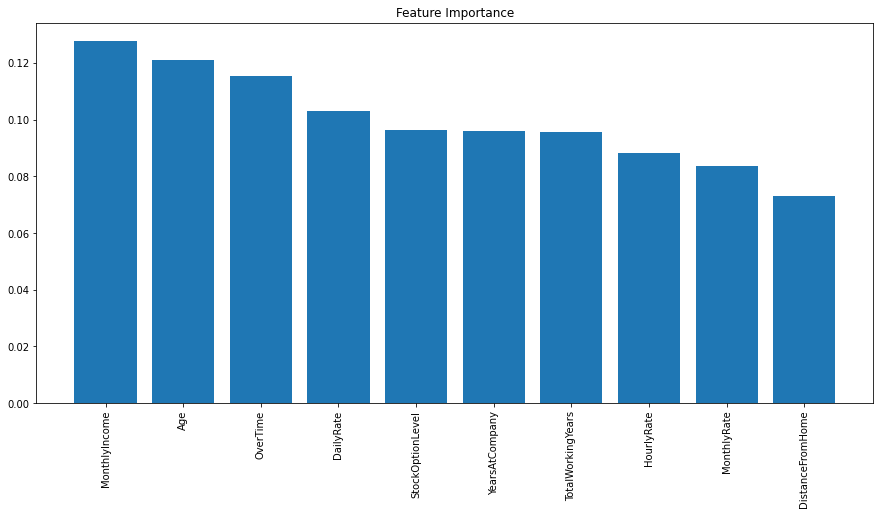

In [8]:
# Finding feature importance
import matplotlib.pyplot as plt
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [9]:
# Identify top 10 indicators which affect employee churn
importances = rf_opt.feature_importances_
df_param_coeff = pd.DataFrame(columns=['Feature', 'Coefficient'])
# for i in range(44):
for i in range(10):
    feat = X_train.columns[i]
    coeff = importances[i]
    df_param_coeff.loc[i] = (feat, coeff)
df_param_coeff.sort_values(by='Coefficient', ascending=False, inplace=True)
df_param_coeff = df_param_coeff.reset_index(drop=True)
df_param_coeff.head(10)

,Feature,Coefficient
0,MonthlyIncome,0.127779
1,Age,0.121056
2,OverTime,0.115298
3,DailyRate,0.103012
4,StockOptionLevel,0.096323
5,YearsAtCompany,0.096084
6,TotalWorkingYears,0.095569
7,HourlyRate,0.088060
8,MonthlyRate,0.083632
9,DistanceFromHome,0.073186


Accuracy of RandomForest Regression Classifier on test set: 85.71


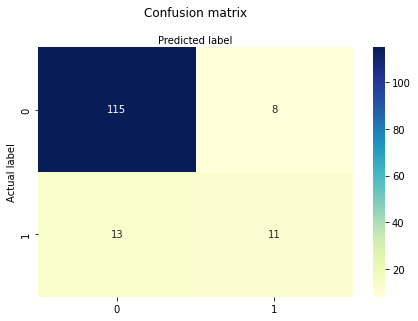

In [10]:
# Evaluation on model outcome
# sklearn modules for performance metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, log_loss
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import average_precision_score
import seaborn as sns

## Confusion Matrix
# The Confusion matrix provides us with a much more detailed representation of the accuracy score 
# and of what's going on with our labels - we know exactly which/how labels were correctly and incorrectly predicted
cnf_matrix = metrics.confusion_matrix(y_test, rf_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print('Accuracy of RandomForest Regression Classifier on test set: {:.2f}'.format(rf_opt.score(X_test, y_test)*100))

In [11]:
# Finding AUC score
rf_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = rf_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
rf_opt_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % rf_opt_roc_auc)

AUC score: 0.755


In [12]:
# Classification report for the optimised Random forest
# rf_opt.fit(X_train, y_train)
print(classification_report(y_test, rf_opt.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       123
         1.0       0.58      0.46      0.51        24

    accuracy                           0.86       147
   macro avg       0.74      0.70      0.71       147
weighted avg       0.85      0.86      0.85       147



In [13]:
# Predict probability of employee who most likely to leave the company
rf_churn_probs = rf_opt.predict_proba(X_train) # predict probabilities
print('len(churn_probs): ', len(rf_churn_probs))
# for score in rf_churn_probs.tolist():
#     print(score[0])
# print ('rf: ',rf_opt)

print('X_train: ',X_train.head(2))
# from tabulate import tabulate
# print(tabulate(X_train))
for score in rf_churn_probs.tolist():
    print(score[0])

len(churn_probs):  588
X_train:           Age  DailyRate  DistanceFromHome  HourlyRate  MonthlyIncome  \
60  1.666667   1.163207          0.000000    0.214286       1.356767   
63  4.880952   4.770938          4.285714    4.928571       1.745129   

    MonthlyRate  OverTime  StockOptionLevel  TotalWorkingYears  YearsAtCompany  
60     1.763301       5.0          1.666667              1.125           1.125  
63     0.052198       0.0          0.000000              3.500           2.625  
0.8779787811802187
0.8652651586930402
0.6916058320655049
0.6696132273069879
0.8386494701147958
0.8849528485251248
0.6540136269635846
0.8747875180454184
0.8536521218054776
0.9478841632701008
0.9343083320432837
0.899996693031906
0.876632805627328
0.405459446582722
0.8467816546756147
0.7762679668279137
0.7597377840165421
0.7346000422343479
0.9596781881230493
0.9636375539893153
0.5264513509344299
0.35992370240727567
0.38341676299916455
0.9135894994290062
0.7970608344218152
0.9461025323594501
0.703736933832

In [14]:
# Let's use logistic regression model to compare the model performance
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

kfold = model_selection.KFold(n_splits=10, random_state=None)
modelCV = LogisticRegression(solver='liblinear',
                             class_weight="balanced", 
                             random_state=None)
scoring = 'roc_auc'
results = model_selection.cross_val_score(
    modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("AUC score (STD): %.2f (%.2f)" % (results.mean(), results.std()))

AUC score (STD): 0.76 (0.12)


In [15]:
param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', # setting GridSearchCV
                                         class_weight="balanced", 
                                         random_state=3),
                                         return_train_score=True,
                                         param_grid=param_grid,
                                         scoring='roc_auc',
                                         cv=10, verbose=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_

print('='*20)
print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)
print('='*20)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
[CV 1/10; 1/200] START C=0.001..................................................
[CV 1/10; 1/200] END C=0.001;, score=(train=0.792, test=0.684) total time=   0.0s
[CV 2/10; 1/200] START C=0.001..................................................
[CV 2/10; 1/200] END C=0.001;, score=(train=0.812, test=0.531) total time=   0.0s
[CV 3/10; 1/200] START C=0.001..................................................
[CV 3/10; 1/200] END C=0.001;, score=(train=0.788, test=0.753) total time=   0.0s
[CV 4/10; 1/200] START C=0.001..................................................
[CV 4/10; 1/200] END C=0.001;, score=(train=0.774, test=0.900) total time=   0.0s
[CV 5/10; 1/200] START C=0.001..................................................
[CV 5/10; 1/200] END C=0.001;, score=(train=0.796, test=0.700) total time=   0.0s
[CV 6/10; 1/200] START C=0.001..................................................
[CV 6/10; 1/200] END C=0.001;, score=(t

[CV 9/10; 5/200] END C=0.040999999999999995;, score=(train=0.792, test=0.832) total time=   0.0s
[CV 10/10; 5/200] START C=0.040999999999999995..................................
[CV 10/10; 5/200] END C=0.040999999999999995;, score=(train=0.794, test=0.823) total time=   0.0s
[CV 1/10; 6/200] START C=0.05099999999999999....................................
[CV 1/10; 6/200] END C=0.05099999999999999;, score=(train=0.806, test=0.676) total time=   0.0s
[CV 2/10; 6/200] START C=0.05099999999999999....................................
[CV 2/10; 6/200] END C=0.05099999999999999;, score=(train=0.825, test=0.544) total time=   0.0s
[CV 3/10; 6/200] START C=0.05099999999999999....................................
[CV 3/10; 6/200] END C=0.05099999999999999;, score=(train=0.806, test=0.747) total time=   0.0s
[CV 4/10; 6/200] START C=0.05099999999999999....................................
[CV 4/10; 6/200] END C=0.05099999999999999;, score=(train=0.796, test=0.853) total time=   0.0s
[CV 5/10; 6/200]

[CV 6/10; 11/200] END C=0.10099999999999998;, score=(train=0.800, test=0.792) total time=   0.0s
[CV 7/10; 11/200] START C=0.10099999999999998...................................
[CV 7/10; 11/200] END C=0.10099999999999998;, score=(train=0.790, test=0.876) total time=   0.0s
[CV 8/10; 11/200] START C=0.10099999999999998...................................
[CV 8/10; 11/200] END C=0.10099999999999998;, score=(train=0.795, test=0.849) total time=   0.0s
[CV 9/10; 11/200] START C=0.10099999999999998...................................
[CV 9/10; 11/200] END C=0.10099999999999998;, score=(train=0.795, test=0.839) total time=   0.0s
[CV 10/10; 11/200] START C=0.10099999999999998..................................
[CV 10/10; 11/200] END C=0.10099999999999998;, score=(train=0.795, test=0.825) total time=   0.0s
[CV 1/10; 12/200] START C=0.11099999999999999...................................
[CV 1/10; 12/200] END C=0.11099999999999999;, score=(train=0.808, test=0.671) total time=   0.0s
[CV 2/10; 12

[CV 5/10; 16/200] END C=0.15099999999999997;, score=(train=0.816, test=0.710) total time=   0.0s
[CV 6/10; 16/200] START C=0.15099999999999997...................................
[CV 6/10; 16/200] END C=0.15099999999999997;, score=(train=0.802, test=0.792) total time=   0.0s
[CV 7/10; 16/200] START C=0.15099999999999997...................................
[CV 7/10; 16/200] END C=0.15099999999999997;, score=(train=0.791, test=0.878) total time=   0.0s
[CV 8/10; 16/200] START C=0.15099999999999997...................................
[CV 8/10; 16/200] END C=0.15099999999999997;, score=(train=0.796, test=0.849) total time=   0.0s
[CV 9/10; 16/200] START C=0.15099999999999997...................................
[CV 9/10; 16/200] END C=0.15099999999999997;, score=(train=0.796, test=0.841) total time=   0.0s
[CV 10/10; 16/200] START C=0.15099999999999997..................................
[CV 10/10; 16/200] END C=0.15099999999999997;, score=(train=0.797, test=0.825) total time=   0.0s
[CV 1/10; 17

[CV 8/10; 21/200] END C=0.20099999999999996;, score=(train=0.796, test=0.849) total time=   0.0s
[CV 9/10; 21/200] START C=0.20099999999999996...................................
[CV 9/10; 21/200] END C=0.20099999999999996;, score=(train=0.797, test=0.841) total time=   0.0s
[CV 10/10; 21/200] START C=0.20099999999999996..................................
[CV 10/10; 21/200] END C=0.20099999999999996;, score=(train=0.797, test=0.828) total time=   0.0s
[CV 1/10; 22/200] START C=0.21099999999999997...................................
[CV 1/10; 22/200] END C=0.21099999999999997;, score=(train=0.809, test=0.669) total time=   0.0s
[CV 2/10; 22/200] START C=0.21099999999999997...................................
[CV 2/10; 22/200] END C=0.21099999999999997;, score=(train=0.827, test=0.544) total time=   0.0s
[CV 3/10; 22/200] START C=0.21099999999999997...................................
[CV 3/10; 22/200] END C=0.21099999999999997;, score=(train=0.808, test=0.751) total time=   0.0s
[CV 4/10; 22

[CV 4/10; 26/200] END C=0.25099999999999995;, score=(train=0.801, test=0.827) total time=   0.0s
[CV 5/10; 26/200] START C=0.25099999999999995...................................
[CV 5/10; 26/200] END C=0.25099999999999995;, score=(train=0.817, test=0.710) total time=   0.0s
[CV 6/10; 26/200] START C=0.25099999999999995...................................
[CV 6/10; 26/200] END C=0.25099999999999995;, score=(train=0.803, test=0.798) total time=   0.0s
[CV 7/10; 26/200] START C=0.25099999999999995...................................
[CV 7/10; 26/200] END C=0.25099999999999995;, score=(train=0.792, test=0.880) total time=   0.0s
[CV 8/10; 26/200] START C=0.25099999999999995...................................
[CV 8/10; 26/200] END C=0.25099999999999995;, score=(train=0.797, test=0.849) total time=   0.0s
[CV 9/10; 26/200] START C=0.25099999999999995...................................
[CV 9/10; 26/200] END C=0.25099999999999995;, score=(train=0.797, test=0.844) total time=   0.0s
[CV 10/10; 26

[CV 2/10; 31/200] END C=0.30099999999999993;, score=(train=0.828, test=0.542) total time=   0.0s
[CV 3/10; 31/200] START C=0.30099999999999993...................................
[CV 3/10; 31/200] END C=0.30099999999999993;, score=(train=0.808, test=0.753) total time=   0.0s
[CV 4/10; 31/200] START C=0.30099999999999993...................................
[CV 4/10; 31/200] END C=0.30099999999999993;, score=(train=0.801, test=0.822) total time=   0.0s
[CV 5/10; 31/200] START C=0.30099999999999993...................................
[CV 5/10; 31/200] END C=0.30099999999999993;, score=(train=0.817, test=0.710) total time=   0.0s
[CV 6/10; 31/200] START C=0.30099999999999993...................................
[CV 6/10; 31/200] END C=0.30099999999999993;, score=(train=0.803, test=0.794) total time=   0.0s
[CV 7/10; 31/200] START C=0.30099999999999993...................................
[CV 7/10; 31/200] END C=0.30099999999999993;, score=(train=0.793, test=0.884) total time=   0.0s
[CV 8/10; 31/

[CV 10/10; 35/200] END C=0.34099999999999997;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 36/200] START C=0.3509999999999999....................................
[CV 1/10; 36/200] END C=0.3509999999999999;, score=(train=0.810, test=0.667) total time=   0.0s
[CV 2/10; 36/200] START C=0.3509999999999999....................................
[CV 2/10; 36/200] END C=0.3509999999999999;, score=(train=0.828, test=0.544) total time=   0.0s
[CV 3/10; 36/200] START C=0.3509999999999999....................................
[CV 3/10; 36/200] END C=0.3509999999999999;, score=(train=0.808, test=0.753) total time=   0.0s
[CV 4/10; 36/200] START C=0.3509999999999999....................................
[CV 4/10; 36/200] END C=0.3509999999999999;, score=(train=0.801, test=0.822) total time=   0.0s
[CV 5/10; 36/200] START C=0.3509999999999999....................................
[CV 5/10; 36/200] END C=0.3509999999999999;, score=(train=0.817, test=0.708) total time=   0.0s
[CV 6/10; 36/200]

[CV 5/10; 41/200] END C=0.4009999999999999;, score=(train=0.817, test=0.706) total time=   0.0s
[CV 6/10; 41/200] START C=0.4009999999999999....................................
[CV 6/10; 41/200] END C=0.4009999999999999;, score=(train=0.804, test=0.792) total time=   0.0s
[CV 7/10; 41/200] START C=0.4009999999999999....................................
[CV 7/10; 41/200] END C=0.4009999999999999;, score=(train=0.793, test=0.884) total time=   0.0s
[CV 8/10; 41/200] START C=0.4009999999999999....................................
[CV 8/10; 41/200] END C=0.4009999999999999;, score=(train=0.797, test=0.849) total time=   0.0s
[CV 9/10; 41/200] START C=0.4009999999999999....................................
[CV 9/10; 41/200] END C=0.4009999999999999;, score=(train=0.798, test=0.846) total time=   0.0s
[CV 10/10; 41/200] START C=0.4009999999999999...................................
[CV 10/10; 41/200] END C=0.4009999999999999;, score=(train=0.798, test=0.825) total time=   0.0s
[CV 1/10; 42/200] 

[CV 2/10; 46/200] END C=0.45099999999999996;, score=(train=0.828, test=0.547) total time=   0.0s
[CV 3/10; 46/200] START C=0.45099999999999996...................................
[CV 3/10; 46/200] END C=0.45099999999999996;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 46/200] START C=0.45099999999999996...................................
[CV 4/10; 46/200] END C=0.45099999999999996;, score=(train=0.801, test=0.822) total time=   0.0s
[CV 5/10; 46/200] START C=0.45099999999999996...................................
[CV 5/10; 46/200] END C=0.45099999999999996;, score=(train=0.817, test=0.706) total time=   0.0s
[CV 6/10; 46/200] START C=0.45099999999999996...................................
[CV 6/10; 46/200] END C=0.45099999999999996;, score=(train=0.804, test=0.792) total time=   0.0s
[CV 7/10; 46/200] START C=0.45099999999999996...................................
[CV 7/10; 46/200] END C=0.45099999999999996;, score=(train=0.793, test=0.884) total time=   0.0s
[CV 8/10; 46/

[CV 9/10; 50/200] END C=0.49099999999999994;, score=(train=0.798, test=0.846) total time=   0.0s
[CV 10/10; 50/200] START C=0.49099999999999994..................................
[CV 10/10; 50/200] END C=0.49099999999999994;, score=(train=0.798, test=0.825) total time=   0.0s
[CV 1/10; 51/200] START C=0.5009999999999999....................................
[CV 1/10; 51/200] END C=0.5009999999999999;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 51/200] START C=0.5009999999999999....................................
[CV 2/10; 51/200] END C=0.5009999999999999;, score=(train=0.828, test=0.547) total time=   0.0s
[CV 3/10; 51/200] START C=0.5009999999999999....................................
[CV 3/10; 51/200] END C=0.5009999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 51/200] START C=0.5009999999999999....................................
[CV 4/10; 51/200] END C=0.5009999999999999;, score=(train=0.801, test=0.822) total time=   0.0s
[CV 5/10; 51/200

[CV 4/10; 56/200] END C=0.5509999999999999;, score=(train=0.802, test=0.820) total time=   0.0s
[CV 5/10; 56/200] START C=0.5509999999999999....................................
[CV 5/10; 56/200] END C=0.5509999999999999;, score=(train=0.817, test=0.708) total time=   0.0s
[CV 6/10; 56/200] START C=0.5509999999999999....................................
[CV 6/10; 56/200] END C=0.5509999999999999;, score=(train=0.805, test=0.794) total time=   0.0s
[CV 7/10; 56/200] START C=0.5509999999999999....................................
[CV 7/10; 56/200] END C=0.5509999999999999;, score=(train=0.793, test=0.884) total time=   0.0s
[CV 8/10; 56/200] START C=0.5509999999999999....................................
[CV 8/10; 56/200] END C=0.5509999999999999;, score=(train=0.797, test=0.847) total time=   0.0s
[CV 9/10; 56/200] START C=0.5509999999999999....................................
[CV 9/10; 56/200] END C=0.5509999999999999;, score=(train=0.798, test=0.846) total time=   0.0s
[CV 10/10; 56/200] 

[CV 3/10; 61/200] END C=0.6009999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 61/200] START C=0.6009999999999999....................................
[CV 4/10; 61/200] END C=0.6009999999999999;, score=(train=0.802, test=0.820) total time=   0.0s
[CV 5/10; 61/200] START C=0.6009999999999999....................................
[CV 5/10; 61/200] END C=0.6009999999999999;, score=(train=0.817, test=0.708) total time=   0.0s
[CV 6/10; 61/200] START C=0.6009999999999999....................................
[CV 6/10; 61/200] END C=0.6009999999999999;, score=(train=0.805, test=0.794) total time=   0.0s
[CV 7/10; 61/200] START C=0.6009999999999999....................................
[CV 7/10; 61/200] END C=0.6009999999999999;, score=(train=0.793, test=0.884) total time=   0.0s
[CV 8/10; 61/200] START C=0.6009999999999999....................................
[CV 8/10; 61/200] END C=0.6009999999999999;, score=(train=0.797, test=0.847) total time=   0.0s
[CV 9/10; 61/200] S

[CV 8/10; 66/200] END C=0.6509999999999999;, score=(train=0.797, test=0.847) total time=   0.0s
[CV 9/10; 66/200] START C=0.6509999999999999....................................
[CV 9/10; 66/200] END C=0.6509999999999999;, score=(train=0.798, test=0.844) total time=   0.0s
[CV 10/10; 66/200] START C=0.6509999999999999...................................
[CV 10/10; 66/200] END C=0.6509999999999999;, score=(train=0.798, test=0.825) total time=   0.0s
[CV 1/10; 67/200] START C=0.6609999999999999....................................
[CV 1/10; 67/200] END C=0.6609999999999999;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 67/200] START C=0.6609999999999999....................................
[CV 2/10; 67/200] END C=0.6609999999999999;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 67/200] START C=0.6609999999999999....................................
[CV 3/10; 67/200] END C=0.6609999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 67/200] 

[CV 8/10; 71/200] END C=0.7009999999999998;, score=(train=0.798, test=0.851) total time=   0.0s
[CV 9/10; 71/200] START C=0.7009999999999998....................................
[CV 9/10; 71/200] END C=0.7009999999999998;, score=(train=0.798, test=0.844) total time=   0.0s
[CV 10/10; 71/200] START C=0.7009999999999998...................................
[CV 10/10; 71/200] END C=0.7009999999999998;, score=(train=0.798, test=0.825) total time=   0.0s
[CV 1/10; 72/200] START C=0.7109999999999999....................................
[CV 1/10; 72/200] END C=0.7109999999999999;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 72/200] START C=0.7109999999999999....................................
[CV 2/10; 72/200] END C=0.7109999999999999;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 72/200] START C=0.7109999999999999....................................
[CV 3/10; 72/200] END C=0.7109999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 72/200] 

[CV 1/10; 77/200] END C=0.7609999999999999;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 77/200] START C=0.7609999999999999....................................
[CV 2/10; 77/200] END C=0.7609999999999999;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 77/200] START C=0.7609999999999999....................................
[CV 3/10; 77/200] END C=0.7609999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 77/200] START C=0.7609999999999999....................................
[CV 4/10; 77/200] END C=0.7609999999999999;, score=(train=0.802, test=0.808) total time=   0.0s
[CV 5/10; 77/200] START C=0.7609999999999999....................................
[CV 5/10; 77/200] END C=0.7609999999999999;, score=(train=0.817, test=0.710) total time=   0.0s
[CV 6/10; 77/200] START C=0.7609999999999999....................................
[CV 6/10; 77/200] END C=0.7609999999999999;, score=(train=0.805, test=0.794) total time=   0.0s
[CV 7/10; 77/200] S

[CV 9/10; 81/200] END C=0.8009999999999998;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 81/200] START C=0.8009999999999998...................................
[CV 10/10; 81/200] END C=0.8009999999999998;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 82/200] START C=0.8109999999999998....................................
[CV 1/10; 82/200] END C=0.8109999999999998;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 82/200] START C=0.8109999999999998....................................
[CV 2/10; 82/200] END C=0.8109999999999998;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 82/200] START C=0.8109999999999998....................................
[CV 3/10; 82/200] END C=0.8109999999999998;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 82/200] START C=0.8109999999999998....................................
[CV 4/10; 82/200] END C=0.8109999999999998;, score=(train=0.802, test=0.806) total time=   0.0s
[CV 5/10; 82/200] 

[CV 4/10; 87/200] END C=0.8609999999999999;, score=(train=0.802, test=0.806) total time=   0.0s
[CV 5/10; 87/200] START C=0.8609999999999999....................................
[CV 5/10; 87/200] END C=0.8609999999999999;, score=(train=0.817, test=0.714) total time=   0.0s
[CV 6/10; 87/200] START C=0.8609999999999999....................................
[CV 6/10; 87/200] END C=0.8609999999999999;, score=(train=0.805, test=0.792) total time=   0.0s
[CV 7/10; 87/200] START C=0.8609999999999999....................................
[CV 7/10; 87/200] END C=0.8609999999999999;, score=(train=0.793, test=0.886) total time=   0.0s
[CV 8/10; 87/200] START C=0.8609999999999999....................................
[CV 8/10; 87/200] END C=0.8609999999999999;, score=(train=0.798, test=0.851) total time=   0.0s
[CV 9/10; 87/200] START C=0.8609999999999999....................................
[CV 9/10; 87/200] END C=0.8609999999999999;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 87/200] 

[CV 3/10; 92/200] END C=0.9109999999999998;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 92/200] START C=0.9109999999999998....................................
[CV 4/10; 92/200] END C=0.9109999999999998;, score=(train=0.802, test=0.804) total time=   0.0s
[CV 5/10; 92/200] START C=0.9109999999999998....................................
[CV 5/10; 92/200] END C=0.9109999999999998;, score=(train=0.817, test=0.714) total time=   0.0s
[CV 6/10; 92/200] START C=0.9109999999999998....................................
[CV 6/10; 92/200] END C=0.9109999999999998;, score=(train=0.805, test=0.792) total time=   0.0s
[CV 7/10; 92/200] START C=0.9109999999999998....................................
[CV 7/10; 92/200] END C=0.9109999999999998;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 92/200] START C=0.9109999999999998....................................
[CV 8/10; 92/200] END C=0.9109999999999998;, score=(train=0.798, test=0.851) total time=   0.0s
[CV 9/10; 92/200] S

[CV 8/10; 97/200] END C=0.9609999999999999;, score=(train=0.798, test=0.853) total time=   0.0s
[CV 9/10; 97/200] START C=0.9609999999999999....................................
[CV 9/10; 97/200] END C=0.9609999999999999;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 97/200] START C=0.9609999999999999...................................
[CV 10/10; 97/200] END C=0.9609999999999999;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 98/200] START C=0.9709999999999999....................................
[CV 1/10; 98/200] END C=0.9709999999999999;, score=(train=0.810, test=0.669) total time=   0.0s
[CV 2/10; 98/200] START C=0.9709999999999999....................................
[CV 2/10; 98/200] END C=0.9709999999999999;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 98/200] START C=0.9709999999999999....................................
[CV 3/10; 98/200] END C=0.9709999999999999;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 98/200] 

[CV 8/10; 102/200] END C=1.0109999999999997;, score=(train=0.798, test=0.853) total time=   0.0s
[CV 9/10; 102/200] START C=1.0109999999999997...................................
[CV 9/10; 102/200] END C=1.0109999999999997;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 102/200] START C=1.0109999999999997..................................
[CV 10/10; 102/200] END C=1.0109999999999997;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 103/200] START C=1.0209999999999997...................................
[CV 1/10; 103/200] END C=1.0209999999999997;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 103/200] START C=1.0209999999999997...................................
[CV 2/10; 103/200] END C=1.0209999999999997;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 103/200] START C=1.0209999999999997...................................
[CV 3/10; 103/200] END C=1.0209999999999997;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 10

[CV 3/10; 108/200] END C=1.0709999999999997;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 108/200] START C=1.0709999999999997...................................
[CV 4/10; 108/200] END C=1.0709999999999997;, score=(train=0.802, test=0.802) total time=   0.0s
[CV 5/10; 108/200] START C=1.0709999999999997...................................
[CV 5/10; 108/200] END C=1.0709999999999997;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 108/200] START C=1.0709999999999997...................................
[CV 6/10; 108/200] END C=1.0709999999999997;, score=(train=0.805, test=0.790) total time=   0.0s
[CV 7/10; 108/200] START C=1.0709999999999997...................................
[CV 7/10; 108/200] END C=1.0709999999999997;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 108/200] START C=1.0709999999999997...................................
[CV 8/10; 108/200] END C=1.0709999999999997;, score=(train=0.798, test=0.851) total time=   0.0s
[CV 9/10; 108

[CV 2/10; 113/200] END C=1.1209999999999998;, score=(train=0.829, test=0.549) total time=   0.0s
[CV 3/10; 113/200] START C=1.1209999999999998...................................
[CV 3/10; 113/200] END C=1.1209999999999998;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 113/200] START C=1.1209999999999998...................................
[CV 4/10; 113/200] END C=1.1209999999999998;, score=(train=0.802, test=0.802) total time=   0.0s
[CV 5/10; 113/200] START C=1.1209999999999998...................................
[CV 5/10; 113/200] END C=1.1209999999999998;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 113/200] START C=1.1209999999999998...................................
[CV 6/10; 113/200] END C=1.1209999999999998;, score=(train=0.805, test=0.790) total time=   0.0s
[CV 7/10; 113/200] START C=1.1209999999999998...................................
[CV 7/10; 113/200] END C=1.1209999999999998;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 113

[CV 6/10; 118/200] END C=1.1709999999999998;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 118/200] START C=1.1709999999999998...................................
[CV 7/10; 118/200] END C=1.1709999999999998;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 118/200] START C=1.1709999999999998...................................
[CV 8/10; 118/200] END C=1.1709999999999998;, score=(train=0.798, test=0.851) total time=   0.0s
[CV 9/10; 118/200] START C=1.1709999999999998...................................
[CV 9/10; 118/200] END C=1.1709999999999998;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 118/200] START C=1.1709999999999998..................................
[CV 10/10; 118/200] END C=1.1709999999999998;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 119/200] START C=1.1809999999999996...................................
[CV 1/10; 119/200] END C=1.1809999999999996;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 11

[CV 2/10; 123/200] END C=1.2209999999999996;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 123/200] START C=1.2209999999999996...................................
[CV 3/10; 123/200] END C=1.2209999999999996;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 123/200] START C=1.2209999999999996...................................
[CV 4/10; 123/200] END C=1.2209999999999996;, score=(train=0.802, test=0.802) total time=   0.0s
[CV 5/10; 123/200] START C=1.2209999999999996...................................
[CV 5/10; 123/200] END C=1.2209999999999996;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 123/200] START C=1.2209999999999996...................................
[CV 6/10; 123/200] END C=1.2209999999999996;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 123/200] START C=1.2209999999999996...................................
[CV 7/10; 123/200] END C=1.2209999999999996;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 123

[CV 6/10; 128/200] END C=1.2709999999999997;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 128/200] START C=1.2709999999999997...................................
[CV 7/10; 128/200] END C=1.2709999999999997;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 128/200] START C=1.2709999999999997...................................
[CV 8/10; 128/200] END C=1.2709999999999997;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 128/200] START C=1.2709999999999997...................................
[CV 9/10; 128/200] END C=1.2709999999999997;, score=(train=0.799, test=0.841) total time=   0.0s
[CV 10/10; 128/200] START C=1.2709999999999997..................................
[CV 10/10; 128/200] END C=1.2709999999999997;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 129/200] START C=1.2809999999999997...................................
[CV 1/10; 129/200] END C=1.2809999999999997;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 12

[CV 4/10; 133/200] END C=1.3209999999999997;, score=(train=0.802, test=0.802) total time=   0.0s
[CV 5/10; 133/200] START C=1.3209999999999997...................................
[CV 5/10; 133/200] END C=1.3209999999999997;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 133/200] START C=1.3209999999999997...................................
[CV 6/10; 133/200] END C=1.3209999999999997;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 133/200] START C=1.3209999999999997...................................
[CV 7/10; 133/200] END C=1.3209999999999997;, score=(train=0.794, test=0.886) total time=   0.0s
[CV 8/10; 133/200] START C=1.3209999999999997...................................
[CV 8/10; 133/200] END C=1.3209999999999997;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 133/200] START C=1.3209999999999997...................................
[CV 9/10; 133/200] END C=1.3209999999999997;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 13

[CV 8/10; 138/200] END C=1.3709999999999998;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 138/200] START C=1.3709999999999998...................................
[CV 9/10; 138/200] END C=1.3709999999999998;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 138/200] START C=1.3709999999999998..................................
[CV 10/10; 138/200] END C=1.3709999999999998;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 139/200] START C=1.3809999999999998...................................
[CV 1/10; 139/200] END C=1.3809999999999998;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 139/200] START C=1.3809999999999998...................................
[CV 2/10; 139/200] END C=1.3809999999999998;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 139/200] START C=1.3809999999999998...................................
[CV 3/10; 139/200] END C=1.3809999999999998;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 13

[CV 5/10; 143/200] END C=1.4209999999999996;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 143/200] START C=1.4209999999999996...................................
[CV 6/10; 143/200] END C=1.4209999999999996;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 143/200] START C=1.4209999999999996...................................
[CV 7/10; 143/200] END C=1.4209999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 143/200] START C=1.4209999999999996...................................
[CV 8/10; 143/200] END C=1.4209999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 143/200] START C=1.4209999999999996...................................
[CV 9/10; 143/200] END C=1.4209999999999996;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 143/200] START C=1.4209999999999996..................................
[CV 10/10; 143/200] END C=1.4209999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 14

[CV 5/10; 148/200] END C=1.4709999999999996;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 148/200] START C=1.4709999999999996...................................
[CV 6/10; 148/200] END C=1.4709999999999996;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 148/200] START C=1.4709999999999996...................................
[CV 7/10; 148/200] END C=1.4709999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 148/200] START C=1.4709999999999996...................................
[CV 8/10; 148/200] END C=1.4709999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 148/200] START C=1.4709999999999996...................................
[CV 9/10; 148/200] END C=1.4709999999999996;, score=(train=0.798, test=0.841) total time=   0.0s
[CV 10/10; 148/200] START C=1.4709999999999996..................................
[CV 10/10; 148/200] END C=1.4709999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 14

[CV 8/10; 153/200] END C=1.5209999999999997;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 153/200] START C=1.5209999999999997...................................
[CV 9/10; 153/200] END C=1.5209999999999997;, score=(train=0.798, test=0.839) total time=   0.0s
[CV 10/10; 153/200] START C=1.5209999999999997..................................
[CV 10/10; 153/200] END C=1.5209999999999997;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 154/200] START C=1.5309999999999997...................................
[CV 1/10; 154/200] END C=1.5309999999999997;, score=(train=0.811, test=0.671) total time=   0.0s
[CV 2/10; 154/200] START C=1.5309999999999997...................................
[CV 2/10; 154/200] END C=1.5309999999999997;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 154/200] START C=1.5309999999999997...................................
[CV 3/10; 154/200] END C=1.5309999999999997;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 15

[CV 4/10; 158/200] END C=1.5709999999999997;, score=(train=0.802, test=0.800) total time=   0.0s
[CV 5/10; 158/200] START C=1.5709999999999997...................................
[CV 5/10; 158/200] END C=1.5709999999999997;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 158/200] START C=1.5709999999999997...................................
[CV 6/10; 158/200] END C=1.5709999999999997;, score=(train=0.805, test=0.788) total time=   0.0s
[CV 7/10; 158/200] START C=1.5709999999999997...................................
[CV 7/10; 158/200] END C=1.5709999999999997;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 158/200] START C=1.5709999999999997...................................
[CV 8/10; 158/200] END C=1.5709999999999997;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 158/200] START C=1.5709999999999997...................................
[CV 9/10; 158/200] END C=1.5709999999999997;, score=(train=0.798, test=0.839) total time=   0.0s
[CV 10/10; 15

[CV 4/10; 163/200] END C=1.6209999999999996;, score=(train=0.802, test=0.800) total time=   0.0s
[CV 5/10; 163/200] START C=1.6209999999999996...................................
[CV 5/10; 163/200] END C=1.6209999999999996;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 163/200] START C=1.6209999999999996...................................
[CV 6/10; 163/200] END C=1.6209999999999996;, score=(train=0.805, test=0.786) total time=   0.0s
[CV 7/10; 163/200] START C=1.6209999999999996...................................
[CV 7/10; 163/200] END C=1.6209999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 163/200] START C=1.6209999999999996...................................
[CV 8/10; 163/200] END C=1.6209999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 163/200] START C=1.6209999999999996...................................
[CV 9/10; 163/200] END C=1.6209999999999996;, score=(train=0.798, test=0.839) total time=   0.0s
[CV 10/10; 16

[CV 7/10; 168/200] END C=1.6709999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 168/200] START C=1.6709999999999996...................................
[CV 8/10; 168/200] END C=1.6709999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 168/200] START C=1.6709999999999996...................................
[CV 9/10; 168/200] END C=1.6709999999999996;, score=(train=0.798, test=0.839) total time=   0.0s
[CV 10/10; 168/200] START C=1.6709999999999996..................................
[CV 10/10; 168/200] END C=1.6709999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 169/200] START C=1.6809999999999996...................................
[CV 1/10; 169/200] END C=1.6809999999999996;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 169/200] START C=1.6809999999999996...................................
[CV 2/10; 169/200] END C=1.6809999999999996;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 16

[CV 6/10; 173/200] END C=1.7209999999999996;, score=(train=0.805, test=0.786) total time=   0.0s
[CV 7/10; 173/200] START C=1.7209999999999996...................................
[CV 7/10; 173/200] END C=1.7209999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 173/200] START C=1.7209999999999996...................................
[CV 8/10; 173/200] END C=1.7209999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 173/200] START C=1.7209999999999996...................................
[CV 9/10; 173/200] END C=1.7209999999999996;, score=(train=0.798, test=0.839) total time=   0.0s
[CV 10/10; 173/200] START C=1.7209999999999996..................................
[CV 10/10; 173/200] END C=1.7209999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 174/200] START C=1.7309999999999997...................................
[CV 1/10; 174/200] END C=1.7309999999999997;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 17

[CV 5/10; 178/200] END C=1.7709999999999997;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 178/200] START C=1.7709999999999997...................................
[CV 6/10; 178/200] END C=1.7709999999999997;, score=(train=0.805, test=0.786) total time=   0.0s
[CV 7/10; 178/200] START C=1.7709999999999997...................................
[CV 7/10; 178/200] END C=1.7709999999999997;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 178/200] START C=1.7709999999999997...................................
[CV 8/10; 178/200] END C=1.7709999999999997;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 178/200] START C=1.7709999999999997...................................
[CV 9/10; 178/200] END C=1.7709999999999997;, score=(train=0.799, test=0.841) total time=   0.0s
[CV 10/10; 178/200] START C=1.7709999999999997..................................
[CV 10/10; 178/200] END C=1.7709999999999997;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 17

[CV 2/10; 183/200] END C=1.8209999999999995;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 183/200] START C=1.8209999999999995...................................
[CV 3/10; 183/200] END C=1.8209999999999995;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 183/200] START C=1.8209999999999995...................................
[CV 4/10; 183/200] END C=1.8209999999999995;, score=(train=0.802, test=0.800) total time=   0.0s
[CV 5/10; 183/200] START C=1.8209999999999995...................................
[CV 5/10; 183/200] END C=1.8209999999999995;, score=(train=0.817, test=0.716) total time=   0.0s
[CV 6/10; 183/200] START C=1.8209999999999995...................................
[CV 6/10; 183/200] END C=1.8209999999999995;, score=(train=0.805, test=0.786) total time=   0.0s
[CV 7/10; 183/200] START C=1.8209999999999995...................................
[CV 7/10; 183/200] END C=1.8209999999999995;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 183

[CV 8/10; 188/200] END C=1.8709999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 188/200] START C=1.8709999999999996...................................
[CV 9/10; 188/200] END C=1.8709999999999996;, score=(train=0.799, test=0.841) total time=   0.0s
[CV 10/10; 188/200] START C=1.8709999999999996..................................
[CV 10/10; 188/200] END C=1.8709999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 189/200] START C=1.8809999999999996...................................
[CV 1/10; 189/200] END C=1.8809999999999996;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 189/200] START C=1.8809999999999996...................................
[CV 2/10; 189/200] END C=1.8809999999999996;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 189/200] START C=1.8809999999999996...................................
[CV 3/10; 189/200] END C=1.8809999999999996;, score=(train=0.809, test=0.753) total time=   0.0s
[CV 4/10; 18

[CV 7/10; 193/200] END C=1.9209999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 193/200] START C=1.9209999999999996...................................
[CV 8/10; 193/200] END C=1.9209999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 193/200] START C=1.9209999999999996...................................
[CV 9/10; 193/200] END C=1.9209999999999996;, score=(train=0.799, test=0.841) total time=   0.0s
[CV 10/10; 193/200] START C=1.9209999999999996..................................
[CV 10/10; 193/200] END C=1.9209999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 194/200] START C=1.9309999999999996...................................
[CV 1/10; 194/200] END C=1.9309999999999996;, score=(train=0.811, test=0.669) total time=   0.0s
[CV 2/10; 194/200] START C=1.9309999999999996...................................
[CV 2/10; 194/200] END C=1.9309999999999996;, score=(train=0.828, test=0.549) total time=   0.0s
[CV 3/10; 19

[CV 5/10; 198/200] END C=1.9709999999999996;, score=(train=0.818, test=0.716) total time=   0.0s
[CV 6/10; 198/200] START C=1.9709999999999996...................................
[CV 6/10; 198/200] END C=1.9709999999999996;, score=(train=0.805, test=0.786) total time=   0.0s
[CV 7/10; 198/200] START C=1.9709999999999996...................................
[CV 7/10; 198/200] END C=1.9709999999999996;, score=(train=0.793, test=0.888) total time=   0.0s
[CV 8/10; 198/200] START C=1.9709999999999996...................................
[CV 8/10; 198/200] END C=1.9709999999999996;, score=(train=0.798, test=0.849) total time=   0.0s
[CV 9/10; 198/200] START C=1.9709999999999996...................................
[CV 9/10; 198/200] END C=1.9709999999999996;, score=(train=0.799, test=0.841) total time=   0.0s
[CV 10/10; 198/200] START C=1.9709999999999996..................................
[CV 10/10; 198/200] END C=1.9709999999999996;, score=(train=0.798, test=0.828) total time=   0.0s
[CV 1/10; 19

Accuracy of Logistic Regression Classifier on test set: 72.11


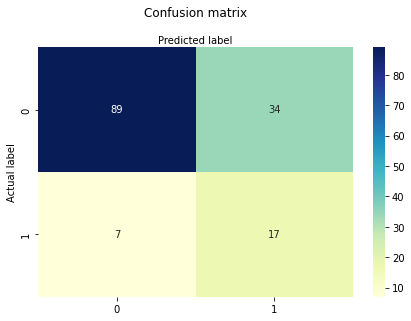

In [16]:
## Confusion Matrix
cnf_matrix = metrics.confusion_matrix(y_test, log_opt.predict(X_test))
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print('Accuracy of Logistic Regression Classifier on test set: {:.2f}'.format(log_opt.score(X_test, y_test)*100))

In [17]:
# Classification report for the optimised Log Regression
log_opt.fit(X_train, y_train)
print(classification_report(y_test, log_opt.predict(X_test)))
log_opt.fit(X_train, y_train) # fit optimised model to the training data
probs = log_opt.predict_proba(X_test) # predict probabilities
probs = probs[:, 1] # we will only keep probabilities associated with the employee leaving
logit_roc_auc = roc_auc_score(y_test, probs) # calculate AUC score using test dataset
print('AUC score: %.3f' % logit_roc_auc)

              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81       123
         1.0       0.33      0.71      0.45        24

    accuracy                           0.72       147
   macro avg       0.63      0.72      0.63       147
weighted avg       0.83      0.72      0.75       147

AUC score: 0.770


In [18]:
# Predict probability of employee who most likely to leave the company
log_churn_probs = log_grid.predict_proba(X_train) # predict probabilities
print('len(churn_probs): ', len(log_churn_probs))
for score in log_churn_probs.tolist():
    print(score[0])



len(churn_probs):  588
0.3641737626449032
0.8263193104622716
0.650579566349843
0.2031573633432049
0.7347397118197379
0.7200939215188235
0.4095471148706661
0.2899265692733155
0.6331898768139228
0.5640561787426328
0.39046963265493273
0.6453828091190978
0.6830200553346535
0.666410256468682
0.43293867054409585
0.6138575264344613
0.6261520569693061
0.37787269609696883
0.735295853068107
0.8562445035251786
0.22349203138077978
0.6155761949825382
0.5567316733572705
0.7404695573852329
0.5679174383502863
0.6735995440357231
0.29327665728867214
0.5471170742526021
0.6369102091219094
0.5961882941686425
0.37252572650438054
0.6255504877319731
0.3739633347141945
0.6608738449427982
0.5774533669223417
0.5451466429075218
0.8295149183873404
0.5014973647701786
0.3341808802998696
0.6194741597998878
0.473503765348785
0.8991367493536632
0.6710666930803648
0.5148070857511187
0.5364569891335258
0.44835938288415156
0.8541686532299618
0.7079250533560099
0.34062700083562825
0.7849006749321646
0.1906388312421129
0.70

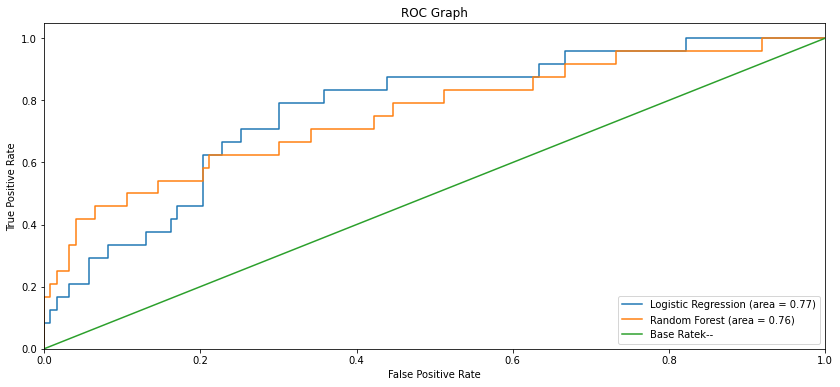

In [19]:
# Create ROC Graph

# AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. 
# ROC is a probability curve and 
# AUC represents degree or measure of separability. 
# It tells how much model is capable of distinguishing between classes. 
# The green line represents the ROC curve of a purely random classifier; 
# a good classifier stays as far away from that line as possible (toward the top-left corner).


from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, log_opt.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_opt.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

# Plot Logistic Regression ROC
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_opt_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()